In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as torchv
import numpy as np
import mymodels
import mycoco_emb_mask as mycoco
import torchvision.transforms as transforms
import torch.utils.data as data
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
import os
import pdb
from models.model_embedding_128_mask import Embdding_128 as model_emb

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm as tqdm


In [2]:
print("Torch Version: {}".format(torch.__version__))
print("Cuda Available: {} \t device Count: {}".format(torch.cuda.is_available(), torch.cuda.device_count()))

Torch Version: 1.0.1.post2
Cuda Available: True 	 device Count: 1


In [3]:
BATCH_SIZE = 64
cuda = torch.cuda.is_available()
IMAGE_SIZE = 224

In [4]:
datasets

<module 'torchvision.datasets' from '/nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torchvision/datasets/__init__.py'>

In [5]:
mycoco.CocoDetection?

Init signature:
mycoco.CocoDetection(
    root,
    annFile,
    transform=None,
    target_transform=None,
    categories=None,
    batch_size=32,
)
Docstring:     
`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

Args:
    root (string): Root directory where images are downloaded to.
    annFile (string): Path to json annotation file.
    transform (callable, optional): A function/transform that  takes in an PIL image
        and returns a transformed version. E.g, ``transforms.ToTensor``
    target_transform (callable, optional): A function/transform that takes in the
        target and transforms it.
File:           /nfs/eecs-fserv/share/linzhe/CS535Proj/TestExamples/AutoEncoder/mycoco_emb_mask.py
Type:           type
Subclasses:     


In [6]:
def create_dataset(name='train', batch_size=32):
    dataDir='/scratch/cluster-share/linzhe/cocoDataset/'
    dataType='%s2017'%name
    annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
    root = '%s%s'%(dataDir, dataType)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
    trans = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                transforms.ToTensor()])
    target_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                           transforms.ToTensor()
                                           ]) # normalize to be in [-1, 1]
    coco = mycoco.CocoDetection(root, annFile, transform=trans, target_transform=target_transform, categories=['horse', 'zebra', 'elephant', 'apple', 'orange'])
    cocoloader = data.DataLoader(coco, batch_size, num_workers=4, shuffle=True)
    
    return cocoloader, coco

In [7]:
cocoloader, cocoDataset = create_dataset(name='train', batch_size=BATCH_SIZE)

loading annotations into memory...
Done (t=19.22s)
creating index...
index created!


In [8]:
# check that there exist 10 different classes
np.unique(cocoDataset.categories)

array(['apple', 'elephant', 'horse', 'orange', 'zebra'], dtype='<U8')

torch.Size([64, 3, 224, 224])
(224, 224, 3)


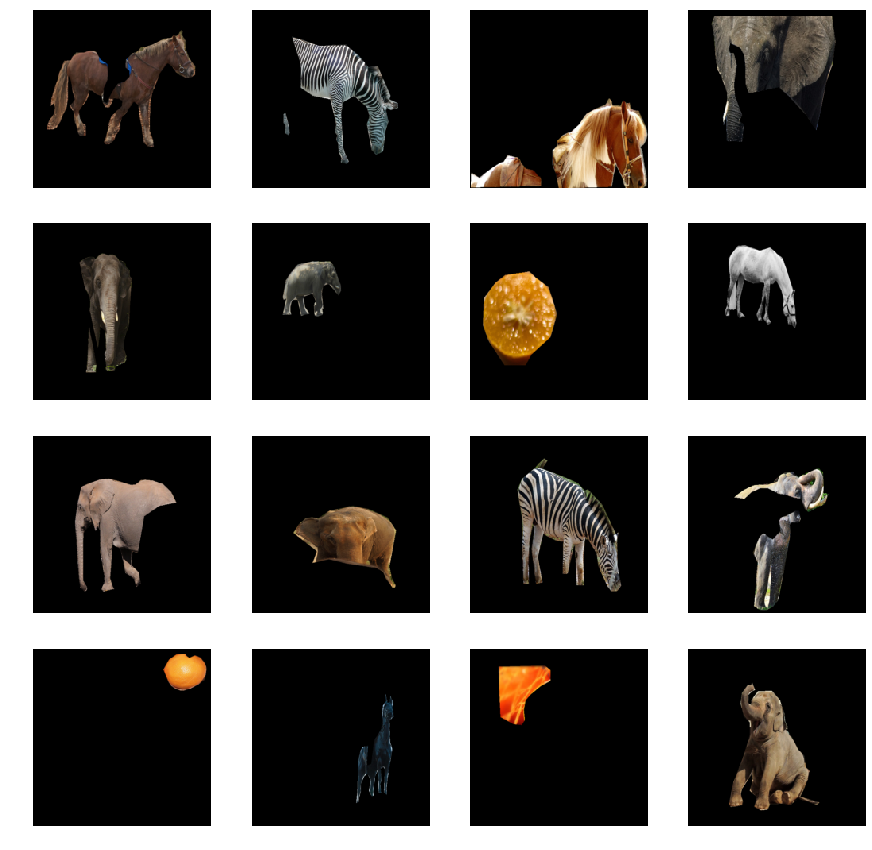

In [9]:
for im, mask in cocoloader:
    print(im.shape)
    print(np.swapaxes(np.swapaxes(im[0].numpy(),0,1),1,2).shape)
    break
    


f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
i = 0
j = 0
for im, mask in  cocoloader:
#     print(im.shape)
    for image in im:
#         print(image.numpy().T.shape)
        axarr[i, j].imshow(np.swapaxes(np.swapaxes(image.numpy(),0,1),1,2))
        axarr[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break

11632.804
3672.4
3364.6553
7757.883
2772.7292
5099.6943
3770.502
8630.22
3832.5098
380.80786
1254.9059
8809.6
3818.051
5000.102
3510.7373
3722.6235


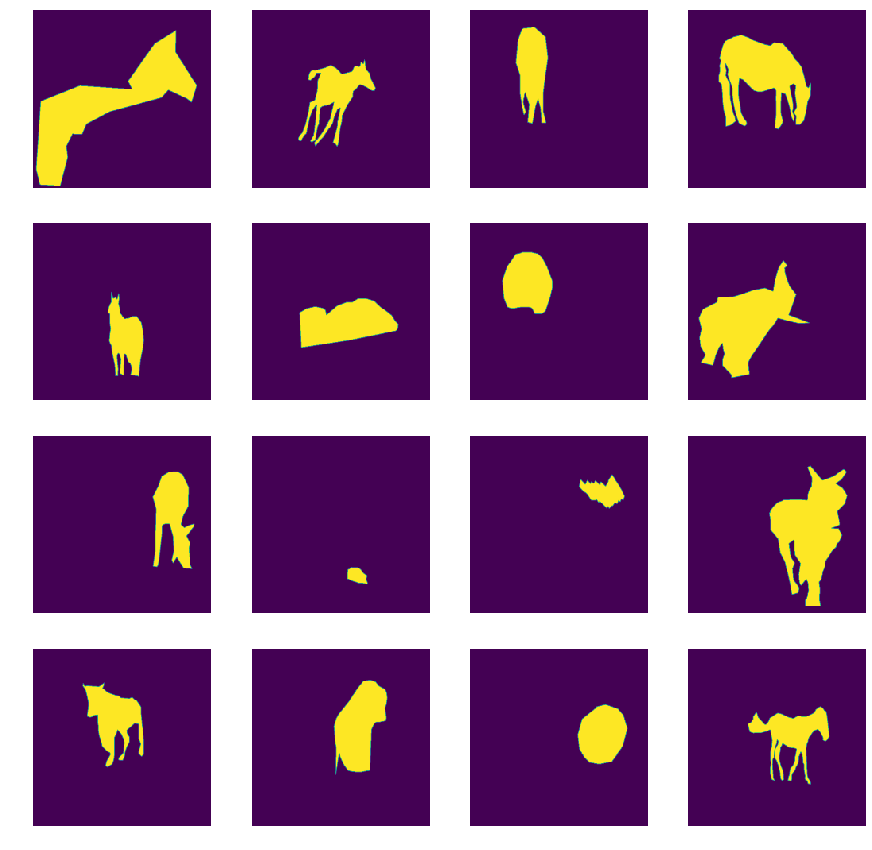

In [10]:

f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
i = 0
j = 0
for im, mask in  cocoloader:
    
    for image in mask:
        print(np.sum(image.numpy()[0]))
#         print(image.numpy()[0])
#         print(image.numpy()[0].shape)
        axarr[i, j].imshow(image.numpy()[0])
        axarr[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break
    

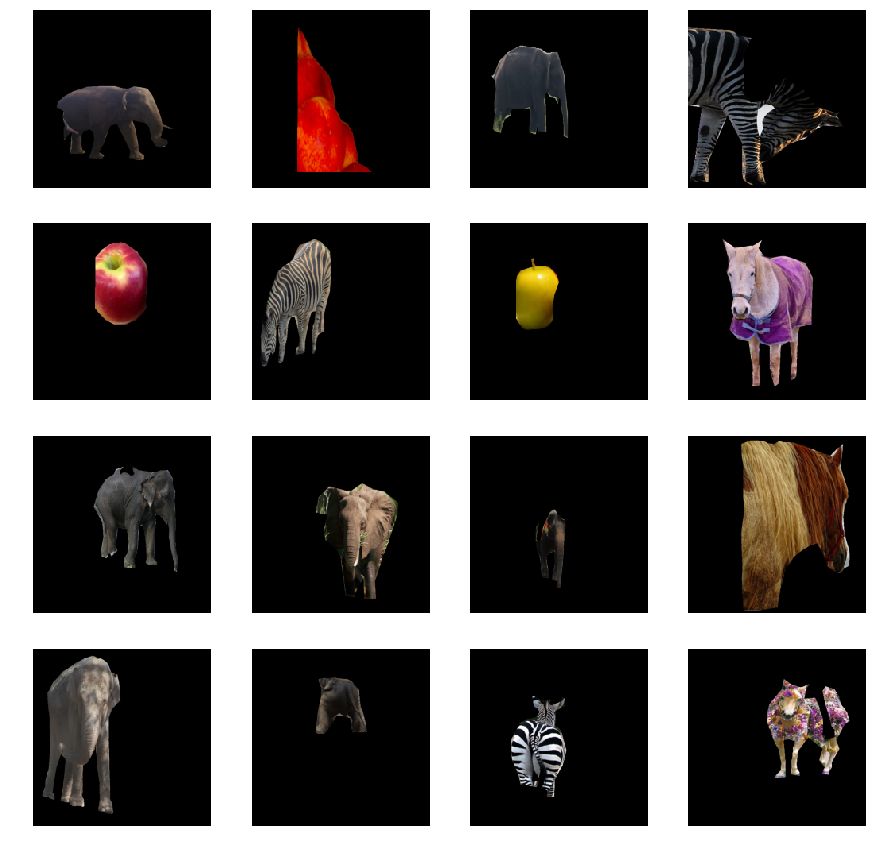

In [11]:
f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
i = 0
j = 0
for im, mask in  cocoloader:
    im = np.multiply(im,mask)
#     print(im.shape)
    for image in im:
#         print(image.numpy().T.shape)
        axarr[i, j].imshow(np.swapaxes(np.swapaxes(image.numpy(),0,1),1,2))
        axarr[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break

In [12]:

data_loader = cocoloader
# pin_memory if you're on GPU

In [13]:
from torch import nn

In [14]:
n_batches = int(np.ceil(len(cocoDataset)/ BATCH_SIZE)) # 60000 / 100

In [15]:
n_batches

69

In [16]:
def deTanh(x):
    return x.add(1).mul(0.5)
def Tanhize(x):
    return x.mul(2).add(-1)

In [ ]:
model = model_emb(IMAGE_SIZE)
if cuda:
    model.cuda()
num_epochs = 10000
#model = nn.DataParallel(model)
model.batch_size = BATCH_SIZE
learning_rate = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in tqdm(list(range(num_epochs))):
    for i, (_, masks) in enumerate(cocoloader):
        images = masks
        #print(images.shape)
        if cuda:
            x = Tanhize(Variable(images).cuda())
        else:
            x = Tanhize(Variable(images))
        #print(x.shape)
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        z, x_hat = model(x)
        #print(x.shape, x_hat.shape)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        if (i + 1) % 30 == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                  %(epoch,
                    num_epochs,
                    i + 1,
                    n_batches,
                    loss.data,
                    loss.data,
                    0,
                    0)
            )

    # Save real images once
#     import pdb
#     pdb.set_trace()
    if (epoch + 1) == 1:
        images = images.view(images.size(0), 1, 224, 224) # reshape
        save_image(images.data, './Experiments/3_animals_2_fruit/mask_data/real_images.png')
    fake_images = deTanh(x_hat)
    # Save sampled images
    #import pdb
    #pdb.set_trace()
    #fake_images = fake_images.view(fake_images.size(0), 3, 28, 28) #reshape
    #print(x_hat[0])
    #print(x_hat[0])
    if epoch % 100 == 0:
        save_image(fake_images.data, './Experiments/3_animals_2_fruit/mask_data/fake_images-%0.3d.png' %(epoch + 1))
#     print(epoch)
    # Save the trained parameters 
    if epoch % 1000 == 0:
        torch.save(model.state_dict(), './Experiments/3_animals_2_fruit/mask_weight/weight_' + str(epoch) + '.pkl')
#     torch.save(D.state_dict(), './weights/discriminator-%0.3d.pkl' %(epoch + 1))
        

  0%|          | 0/10000 [00:00<?, ?it/s]/nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [0/10000], Step[30/69], d_loss: 0.3415, g_loss: 0.3415, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [0/10000], Step[60/69], d_loss: 0.2512, g_loss: 0.2512, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 1/10000 [00:32<89:47:55, 32.33s/it]

Epoch [1/10000], Step[30/69], d_loss: 0.2108, g_loss: 0.2108, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1/10000], Step[60/69], d_loss: 0.1944, g_loss: 0.1944, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 2/10000 [01:03<88:26:20, 31.84s/it]

Epoch [2/10000], Step[30/69], d_loss: 0.1825, g_loss: 0.1825, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2/10000], Step[60/69], d_loss: 0.1469, g_loss: 0.1469, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 3/10000 [01:34<87:44:02, 31.59s/it]

Epoch [3/10000], Step[30/69], d_loss: 0.1983, g_loss: 0.1983, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3/10000], Step[60/69], d_loss: 0.1416, g_loss: 0.1416, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 4/10000 [02:04<86:52:10, 31.29s/it]

Epoch [4/10000], Step[30/69], d_loss: 0.1457, g_loss: 0.1457, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4/10000], Step[60/69], d_loss: 0.1446, g_loss: 0.1446, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 5/10000 [02:35<86:12:35, 31.05s/it]

Epoch [5/10000], Step[30/69], d_loss: 0.1311, g_loss: 0.1311, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [5/10000], Step[60/69], d_loss: 0.1336, g_loss: 0.1336, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 6/10000 [03:05<85:41:35, 30.87s/it]

Epoch [6/10000], Step[30/69], d_loss: 0.1180, g_loss: 0.1180, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [6/10000], Step[60/69], d_loss: 0.1280, g_loss: 0.1280, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 7/10000 [03:36<85:31:08, 30.81s/it]

Epoch [7/10000], Step[30/69], d_loss: 0.1032, g_loss: 0.1032, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [7/10000], Step[60/69], d_loss: 0.1123, g_loss: 0.1123, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 8/10000 [04:06<85:26:39, 30.78s/it]

Epoch [8/10000], Step[30/69], d_loss: 0.1135, g_loss: 0.1135, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [8/10000], Step[60/69], d_loss: 0.1064, g_loss: 0.1064, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 9/10000 [04:37<85:22:21, 30.76s/it]

Epoch [9/10000], Step[30/69], d_loss: 0.0989, g_loss: 0.0989, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [9/10000], Step[60/69], d_loss: 0.1081, g_loss: 0.1081, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 10/10000 [05:08<85:28:35, 30.80s/it]

Epoch [10/10000], Step[30/69], d_loss: 0.1095, g_loss: 0.1095, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [10/10000], Step[60/69], d_loss: 0.1159, g_loss: 0.1159, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 11/10000 [05:40<86:10:33, 31.06s/it]

Epoch [11/10000], Step[30/69], d_loss: 0.0942, g_loss: 0.0942, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [11/10000], Step[60/69], d_loss: 0.1018, g_loss: 0.1018, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 12/10000 [06:11<86:16:46, 31.10s/it]

Epoch [12/10000], Step[30/69], d_loss: 0.0912, g_loss: 0.0912, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [12/10000], Step[60/69], d_loss: 0.0956, g_loss: 0.0956, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 13/10000 [06:42<86:04:25, 31.03s/it]

Epoch [13/10000], Step[30/69], d_loss: 0.0821, g_loss: 0.0821, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [13/10000], Step[60/69], d_loss: 0.0929, g_loss: 0.0929, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 14/10000 [07:13<86:34:17, 31.21s/it]

Epoch [14/10000], Step[30/69], d_loss: 0.1015, g_loss: 0.1015, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [14/10000], Step[60/69], d_loss: 0.0782, g_loss: 0.0782, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 15/10000 [07:44<86:14:37, 31.09s/it]

Epoch [15/10000], Step[30/69], d_loss: 0.0981, g_loss: 0.0981, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [15/10000], Step[60/69], d_loss: 0.0764, g_loss: 0.0764, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 16/10000 [08:15<85:59:33, 31.01s/it]

Epoch [16/10000], Step[30/69], d_loss: 0.0838, g_loss: 0.0838, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [16/10000], Step[60/69], d_loss: 0.0860, g_loss: 0.0860, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 17/10000 [08:46<85:50:37, 30.96s/it]

Epoch [17/10000], Step[30/69], d_loss: 0.0833, g_loss: 0.0833, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [17/10000], Step[60/69], d_loss: 0.0809, g_loss: 0.0809, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 18/10000 [09:17<85:56:43, 31.00s/it]

Epoch [18/10000], Step[30/69], d_loss: 0.0787, g_loss: 0.0787, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [18/10000], Step[60/69], d_loss: 0.0889, g_loss: 0.0889, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 19/10000 [09:48<85:41:01, 30.90s/it]

Epoch [19/10000], Step[30/69], d_loss: 0.0848, g_loss: 0.0848, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [19/10000], Step[60/69], d_loss: 0.0826, g_loss: 0.0826, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 20/10000 [10:19<85:56:33, 31.00s/it]

Epoch [20/10000], Step[30/69], d_loss: 0.0751, g_loss: 0.0751, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20/10000], Step[60/69], d_loss: 0.0718, g_loss: 0.0718, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 21/10000 [10:49<85:20:31, 30.79s/it]

Epoch [21/10000], Step[30/69], d_loss: 0.0761, g_loss: 0.0761, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [21/10000], Step[60/69], d_loss: 0.0793, g_loss: 0.0793, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 22/10000 [11:20<85:01:55, 30.68s/it]

Epoch [22/10000], Step[30/69], d_loss: 0.0655, g_loss: 0.0655, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [22/10000], Step[60/69], d_loss: 0.0661, g_loss: 0.0661, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 23/10000 [11:50<84:58:21, 30.66s/it]

Epoch [23/10000], Step[30/69], d_loss: 0.0730, g_loss: 0.0730, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [23/10000], Step[60/69], d_loss: 0.0747, g_loss: 0.0747, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 24/10000 [12:25<88:10:12, 31.82s/it]

Epoch [24/10000], Step[30/69], d_loss: 0.0738, g_loss: 0.0738, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [24/10000], Step[60/69], d_loss: 0.0661, g_loss: 0.0661, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 25/10000 [12:55<87:04:31, 31.43s/it]

Epoch [25/10000], Step[30/69], d_loss: 0.0724, g_loss: 0.0724, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [25/10000], Step[60/69], d_loss: 0.0717, g_loss: 0.0717, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 26/10000 [13:26<86:08:54, 31.09s/it]

Epoch [26/10000], Step[30/69], d_loss: 0.0647, g_loss: 0.0647, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [26/10000], Step[60/69], d_loss: 0.0658, g_loss: 0.0658, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 27/10000 [13:56<85:15:45, 30.78s/it]

Epoch [27/10000], Step[30/69], d_loss: 0.0667, g_loss: 0.0667, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [27/10000], Step[60/69], d_loss: 0.0727, g_loss: 0.0727, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 28/10000 [14:26<85:02:07, 30.70s/it]

Epoch [28/10000], Step[30/69], d_loss: 0.0639, g_loss: 0.0639, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [28/10000], Step[60/69], d_loss: 0.0641, g_loss: 0.0641, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 29/10000 [14:56<84:40:42, 30.57s/it]

Epoch [29/10000], Step[30/69], d_loss: 0.0678, g_loss: 0.0678, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [29/10000], Step[60/69], d_loss: 0.0663, g_loss: 0.0663, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 30/10000 [15:27<84:53:40, 30.65s/it]

Epoch [30/10000], Step[30/69], d_loss: 0.0623, g_loss: 0.0623, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [30/10000], Step[60/69], d_loss: 0.0643, g_loss: 0.0643, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 31/10000 [15:58<84:56:30, 30.67s/it]

Epoch [31/10000], Step[30/69], d_loss: 0.0569, g_loss: 0.0569, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [31/10000], Step[60/69], d_loss: 0.0562, g_loss: 0.0562, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 32/10000 [16:30<85:49:27, 31.00s/it]

Epoch [32/10000], Step[30/69], d_loss: 0.0646, g_loss: 0.0646, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [32/10000], Step[60/69], d_loss: 0.0716, g_loss: 0.0716, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 33/10000 [17:01<86:20:43, 31.19s/it]

Epoch [33/10000], Step[30/69], d_loss: 0.0547, g_loss: 0.0547, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [33/10000], Step[60/69], d_loss: 0.0586, g_loss: 0.0586, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 34/10000 [17:32<86:09:58, 31.13s/it]

Epoch [34/10000], Step[30/69], d_loss: 0.0607, g_loss: 0.0607, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [34/10000], Step[60/69], d_loss: 0.0567, g_loss: 0.0567, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 35/10000 [18:03<85:55:02, 31.04s/it]

Epoch [35/10000], Step[30/69], d_loss: 0.0572, g_loss: 0.0572, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [35/10000], Step[60/69], d_loss: 0.0565, g_loss: 0.0565, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 36/10000 [18:34<85:31:12, 30.90s/it]

Epoch [36/10000], Step[30/69], d_loss: 0.0633, g_loss: 0.0633, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [36/10000], Step[60/69], d_loss: 0.0544, g_loss: 0.0544, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 37/10000 [19:04<84:53:17, 30.67s/it]

Epoch [37/10000], Step[30/69], d_loss: 0.0534, g_loss: 0.0534, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [37/10000], Step[60/69], d_loss: 0.0696, g_loss: 0.0696, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 38/10000 [19:34<84:49:59, 30.66s/it]

Epoch [38/10000], Step[30/69], d_loss: 0.0593, g_loss: 0.0593, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [38/10000], Step[60/69], d_loss: 0.0526, g_loss: 0.0526, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 39/10000 [20:05<84:35:36, 30.57s/it]

Epoch [39/10000], Step[30/69], d_loss: 0.0576, g_loss: 0.0576, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [39/10000], Step[60/69], d_loss: 0.0581, g_loss: 0.0581, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 40/10000 [20:35<84:26:17, 30.52s/it]

Epoch [40/10000], Step[30/69], d_loss: 0.0567, g_loss: 0.0567, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [40/10000], Step[60/69], d_loss: 0.0624, g_loss: 0.0624, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 41/10000 [21:06<84:32:11, 30.56s/it]

Epoch [41/10000], Step[30/69], d_loss: 0.0552, g_loss: 0.0552, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [41/10000], Step[60/69], d_loss: 0.0535, g_loss: 0.0535, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 42/10000 [21:36<84:24:50, 30.52s/it]

Epoch [42/10000], Step[30/69], d_loss: 0.0508, g_loss: 0.0508, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [42/10000], Step[60/69], d_loss: 0.0511, g_loss: 0.0511, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 43/10000 [22:07<84:11:35, 30.44s/it]

Epoch [43/10000], Step[30/69], d_loss: 0.0539, g_loss: 0.0539, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [43/10000], Step[60/69], d_loss: 0.0579, g_loss: 0.0579, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 44/10000 [22:37<83:53:35, 30.33s/it]

Epoch [44/10000], Step[30/69], d_loss: 0.0599, g_loss: 0.0599, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [44/10000], Step[60/69], d_loss: 0.0585, g_loss: 0.0585, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 45/10000 [23:07<84:11:37, 30.45s/it]

Epoch [45/10000], Step[30/69], d_loss: 0.0594, g_loss: 0.0594, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [45/10000], Step[60/69], d_loss: 0.0512, g_loss: 0.0512, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 46/10000 [23:39<84:56:23, 30.72s/it]

Epoch [46/10000], Step[30/69], d_loss: 0.0543, g_loss: 0.0543, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [46/10000], Step[60/69], d_loss: 0.0547, g_loss: 0.0547, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 47/10000 [24:10<85:02:44, 30.76s/it]

Epoch [47/10000], Step[30/69], d_loss: 0.0508, g_loss: 0.0508, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [47/10000], Step[60/69], d_loss: 0.0542, g_loss: 0.0542, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 48/10000 [24:40<84:36:54, 30.61s/it]

Epoch [48/10000], Step[30/69], d_loss: 0.0521, g_loss: 0.0521, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [48/10000], Step[60/69], d_loss: 0.0549, g_loss: 0.0549, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 49/10000 [25:11<85:08:00, 30.80s/it]

Epoch [49/10000], Step[30/69], d_loss: 0.0510, g_loss: 0.0510, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [49/10000], Step[60/69], d_loss: 0.0498, g_loss: 0.0498, Mean D(x): 0.00, Mean D(G(z)): 0.00


  0%|          | 50/10000 [25:42<85:21:52, 30.89s/it]

Epoch [50/10000], Step[30/69], d_loss: 0.0560, g_loss: 0.0560, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [50/10000], Step[60/69], d_loss: 0.0464, g_loss: 0.0464, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 51/10000 [26:13<85:19:44, 30.88s/it]

Epoch [51/10000], Step[30/69], d_loss: 0.0514, g_loss: 0.0514, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [51/10000], Step[60/69], d_loss: 0.0537, g_loss: 0.0537, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 52/10000 [26:44<85:26:56, 30.92s/it]

Epoch [52/10000], Step[30/69], d_loss: 0.0474, g_loss: 0.0474, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [52/10000], Step[60/69], d_loss: 0.0564, g_loss: 0.0564, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 53/10000 [27:15<85:41:19, 31.01s/it]

Epoch [53/10000], Step[30/69], d_loss: 0.0513, g_loss: 0.0513, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [53/10000], Step[60/69], d_loss: 0.0507, g_loss: 0.0507, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 54/10000 [27:46<85:45:12, 31.04s/it]

Epoch [54/10000], Step[30/69], d_loss: 0.0496, g_loss: 0.0496, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [54/10000], Step[60/69], d_loss: 0.0523, g_loss: 0.0523, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 55/10000 [28:18<86:06:36, 31.17s/it]

Epoch [55/10000], Step[30/69], d_loss: 0.0419, g_loss: 0.0419, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [55/10000], Step[60/69], d_loss: 0.0489, g_loss: 0.0489, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 56/10000 [28:49<85:42:11, 31.03s/it]

Epoch [56/10000], Step[30/69], d_loss: 0.0599, g_loss: 0.0599, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [56/10000], Step[60/69], d_loss: 0.0461, g_loss: 0.0461, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 57/10000 [29:19<85:28:47, 30.95s/it]

Epoch [57/10000], Step[30/69], d_loss: 0.0511, g_loss: 0.0511, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [57/10000], Step[60/69], d_loss: 0.0500, g_loss: 0.0500, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 58/10000 [29:51<85:40:22, 31.02s/it]

Epoch [58/10000], Step[30/69], d_loss: 0.0524, g_loss: 0.0524, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [58/10000], Step[60/69], d_loss: 0.0463, g_loss: 0.0463, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 59/10000 [30:21<85:33:35, 30.98s/it]

Epoch [59/10000], Step[30/69], d_loss: 0.0544, g_loss: 0.0544, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [59/10000], Step[60/69], d_loss: 0.0418, g_loss: 0.0418, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 60/10000 [30:52<85:08:49, 30.84s/it]

Epoch [60/10000], Step[30/69], d_loss: 0.0514, g_loss: 0.0514, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [60/10000], Step[60/69], d_loss: 0.0522, g_loss: 0.0522, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 61/10000 [31:23<85:07:57, 30.84s/it]

Epoch [61/10000], Step[30/69], d_loss: 0.0439, g_loss: 0.0439, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [61/10000], Step[60/69], d_loss: 0.0480, g_loss: 0.0480, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 62/10000 [31:53<84:31:10, 30.62s/it]

Epoch [62/10000], Step[30/69], d_loss: 0.0504, g_loss: 0.0504, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [62/10000], Step[60/69], d_loss: 0.0451, g_loss: 0.0451, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 63/10000 [32:23<84:15:09, 30.52s/it]

Epoch [63/10000], Step[30/69], d_loss: 0.0441, g_loss: 0.0441, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [63/10000], Step[60/69], d_loss: 0.0518, g_loss: 0.0518, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 64/10000 [32:55<85:23:31, 30.94s/it]

Epoch [64/10000], Step[30/69], d_loss: 0.0483, g_loss: 0.0483, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [64/10000], Step[60/69], d_loss: 0.0405, g_loss: 0.0405, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 65/10000 [33:26<85:47:04, 31.08s/it]

Epoch [65/10000], Step[30/69], d_loss: 0.0458, g_loss: 0.0458, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [65/10000], Step[60/69], d_loss: 0.0498, g_loss: 0.0498, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 66/10000 [33:58<85:59:45, 31.16s/it]

Epoch [66/10000], Step[30/69], d_loss: 0.0520, g_loss: 0.0520, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [66/10000], Step[60/69], d_loss: 0.0522, g_loss: 0.0522, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 67/10000 [34:29<85:40:46, 31.05s/it]

Epoch [67/10000], Step[30/69], d_loss: 0.0526, g_loss: 0.0526, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [67/10000], Step[60/69], d_loss: 0.0491, g_loss: 0.0491, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 68/10000 [34:59<85:16:36, 30.91s/it]

Epoch [68/10000], Step[30/69], d_loss: 0.0445, g_loss: 0.0445, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [68/10000], Step[60/69], d_loss: 0.0464, g_loss: 0.0464, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 69/10000 [35:30<84:57:32, 30.80s/it]

Epoch [69/10000], Step[30/69], d_loss: 0.0393, g_loss: 0.0393, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [69/10000], Step[60/69], d_loss: 0.0404, g_loss: 0.0404, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 70/10000 [36:00<84:49:46, 30.75s/it]

Epoch [70/10000], Step[30/69], d_loss: 0.0454, g_loss: 0.0454, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [70/10000], Step[60/69], d_loss: 0.0438, g_loss: 0.0438, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 71/10000 [36:31<84:41:58, 30.71s/it]

Epoch [71/10000], Step[30/69], d_loss: 0.0480, g_loss: 0.0480, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [71/10000], Step[60/69], d_loss: 0.0424, g_loss: 0.0424, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 72/10000 [37:01<84:26:11, 30.62s/it]

Epoch [72/10000], Step[30/69], d_loss: 0.0475, g_loss: 0.0475, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [72/10000], Step[60/69], d_loss: 0.0429, g_loss: 0.0429, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 73/10000 [37:31<83:42:41, 30.36s/it]

Epoch [73/10000], Step[30/69], d_loss: 0.0437, g_loss: 0.0437, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [73/10000], Step[60/69], d_loss: 0.0464, g_loss: 0.0464, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 74/10000 [38:01<83:23:15, 30.24s/it]

Epoch [74/10000], Step[30/69], d_loss: 0.0460, g_loss: 0.0460, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [74/10000], Step[60/69], d_loss: 0.0415, g_loss: 0.0415, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 75/10000 [38:31<83:17:48, 30.21s/it]

Epoch [75/10000], Step[30/69], d_loss: 0.0465, g_loss: 0.0465, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [75/10000], Step[60/69], d_loss: 0.0438, g_loss: 0.0438, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 76/10000 [39:01<83:03:12, 30.13s/it]

Epoch [76/10000], Step[30/69], d_loss: 0.0407, g_loss: 0.0407, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [76/10000], Step[60/69], d_loss: 0.0411, g_loss: 0.0411, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 77/10000 [39:32<83:21:41, 30.24s/it]

Epoch [77/10000], Step[30/69], d_loss: 0.0434, g_loss: 0.0434, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [77/10000], Step[60/69], d_loss: 0.0450, g_loss: 0.0450, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 78/10000 [40:02<83:24:12, 30.26s/it]

Epoch [78/10000], Step[30/69], d_loss: 0.0379, g_loss: 0.0379, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [78/10000], Step[60/69], d_loss: 0.0404, g_loss: 0.0404, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 79/10000 [40:32<83:14:49, 30.21s/it]

Epoch [79/10000], Step[30/69], d_loss: 0.0417, g_loss: 0.0417, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [79/10000], Step[60/69], d_loss: 0.0423, g_loss: 0.0423, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 80/10000 [41:03<83:30:28, 30.31s/it]

Epoch [80/10000], Step[30/69], d_loss: 0.0454, g_loss: 0.0454, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [80/10000], Step[60/69], d_loss: 0.0435, g_loss: 0.0435, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 81/10000 [41:33<83:48:17, 30.42s/it]

Epoch [81/10000], Step[30/69], d_loss: 0.0434, g_loss: 0.0434, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [81/10000], Step[60/69], d_loss: 0.0418, g_loss: 0.0418, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 82/10000 [42:04<83:54:13, 30.46s/it]

Epoch [82/10000], Step[30/69], d_loss: 0.0428, g_loss: 0.0428, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [82/10000], Step[60/69], d_loss: 0.0454, g_loss: 0.0454, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 83/10000 [42:35<84:23:40, 30.64s/it]

Epoch [83/10000], Step[30/69], d_loss: 0.0394, g_loss: 0.0394, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [83/10000], Step[60/69], d_loss: 0.0421, g_loss: 0.0421, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 84/10000 [43:06<85:03:12, 30.88s/it]

Epoch [84/10000], Step[30/69], d_loss: 0.0435, g_loss: 0.0435, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [84/10000], Step[60/69], d_loss: 0.0392, g_loss: 0.0392, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 85/10000 [43:38<85:40:07, 31.11s/it]

Epoch [85/10000], Step[30/69], d_loss: 0.0389, g_loss: 0.0389, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [85/10000], Step[60/69], d_loss: 0.0381, g_loss: 0.0381, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 86/10000 [44:09<85:18:41, 30.98s/it]

Epoch [86/10000], Step[30/69], d_loss: 0.0395, g_loss: 0.0395, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [86/10000], Step[60/69], d_loss: 0.0344, g_loss: 0.0344, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 87/10000 [44:40<85:22:22, 31.00s/it]

Epoch [87/10000], Step[30/69], d_loss: 0.0410, g_loss: 0.0410, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [87/10000], Step[60/69], d_loss: 0.0419, g_loss: 0.0419, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 88/10000 [45:11<85:35:32, 31.09s/it]

Epoch [88/10000], Step[30/69], d_loss: 0.0420, g_loss: 0.0420, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [88/10000], Step[60/69], d_loss: 0.0456, g_loss: 0.0456, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 89/10000 [45:42<85:36:06, 31.09s/it]

Epoch [89/10000], Step[30/69], d_loss: 0.0397, g_loss: 0.0397, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [89/10000], Step[60/69], d_loss: 0.0397, g_loss: 0.0397, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 90/10000 [46:13<85:13:26, 30.96s/it]

Epoch [90/10000], Step[30/69], d_loss: 0.0400, g_loss: 0.0400, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [90/10000], Step[60/69], d_loss: 0.0382, g_loss: 0.0382, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 91/10000 [46:44<85:20:36, 31.01s/it]

Epoch [91/10000], Step[30/69], d_loss: 0.0377, g_loss: 0.0377, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [91/10000], Step[60/69], d_loss: 0.0343, g_loss: 0.0343, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 92/10000 [47:15<85:37:24, 31.11s/it]

Epoch [92/10000], Step[30/69], d_loss: 0.0391, g_loss: 0.0391, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [92/10000], Step[60/69], d_loss: 0.0446, g_loss: 0.0446, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 93/10000 [47:47<85:45:39, 31.16s/it]

Epoch [93/10000], Step[30/69], d_loss: 0.0384, g_loss: 0.0384, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [93/10000], Step[60/69], d_loss: 0.0411, g_loss: 0.0411, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 94/10000 [48:17<85:16:07, 30.99s/it]

Epoch [94/10000], Step[30/69], d_loss: 0.0339, g_loss: 0.0339, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [94/10000], Step[60/69], d_loss: 0.0412, g_loss: 0.0412, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 95/10000 [48:48<85:03:45, 30.92s/it]

Epoch [95/10000], Step[30/69], d_loss: 0.0385, g_loss: 0.0385, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [95/10000], Step[60/69], d_loss: 0.0345, g_loss: 0.0345, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 96/10000 [49:18<84:33:49, 30.74s/it]

Epoch [96/10000], Step[30/69], d_loss: 0.0375, g_loss: 0.0375, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [96/10000], Step[60/69], d_loss: 0.0351, g_loss: 0.0351, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 97/10000 [49:49<84:29:35, 30.72s/it]

Epoch [97/10000], Step[30/69], d_loss: 0.0407, g_loss: 0.0407, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [97/10000], Step[60/69], d_loss: 0.0382, g_loss: 0.0382, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 98/10000 [50:19<84:07:06, 30.58s/it]

Epoch [98/10000], Step[30/69], d_loss: 0.0397, g_loss: 0.0397, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [98/10000], Step[60/69], d_loss: 0.0391, g_loss: 0.0391, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 99/10000 [50:51<85:09:27, 30.96s/it]

Epoch [99/10000], Step[30/69], d_loss: 0.0326, g_loss: 0.0326, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [99/10000], Step[60/69], d_loss: 0.0420, g_loss: 0.0420, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 100/10000 [51:22<85:25:15, 31.06s/it]

Epoch [100/10000], Step[30/69], d_loss: 0.0400, g_loss: 0.0400, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [100/10000], Step[60/69], d_loss: 0.0401, g_loss: 0.0401, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 101/10000 [51:53<85:27:39, 31.08s/it]

Epoch [101/10000], Step[30/69], d_loss: 0.0386, g_loss: 0.0386, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [101/10000], Step[60/69], d_loss: 0.0376, g_loss: 0.0376, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 102/10000 [52:24<85:07:42, 30.96s/it]

Epoch [102/10000], Step[30/69], d_loss: 0.0412, g_loss: 0.0412, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [102/10000], Step[60/69], d_loss: 0.0404, g_loss: 0.0404, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 103/10000 [52:54<84:10:08, 30.62s/it]

Epoch [103/10000], Step[30/69], d_loss: 0.0353, g_loss: 0.0353, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [103/10000], Step[60/69], d_loss: 0.0346, g_loss: 0.0346, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 104/10000 [53:23<83:05:56, 30.23s/it]

Epoch [104/10000], Step[30/69], d_loss: 0.0391, g_loss: 0.0391, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [104/10000], Step[60/69], d_loss: 0.0371, g_loss: 0.0371, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 105/10000 [53:54<83:37:05, 30.42s/it]

Epoch [105/10000], Step[30/69], d_loss: 0.0419, g_loss: 0.0419, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [105/10000], Step[60/69], d_loss: 0.0376, g_loss: 0.0376, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 106/10000 [54:25<83:59:42, 30.56s/it]

Epoch [106/10000], Step[30/69], d_loss: 0.0409, g_loss: 0.0409, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [106/10000], Step[60/69], d_loss: 0.0408, g_loss: 0.0408, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 107/10000 [54:56<84:29:12, 30.74s/it]

Epoch [107/10000], Step[30/69], d_loss: 0.0393, g_loss: 0.0393, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [107/10000], Step[60/69], d_loss: 0.0324, g_loss: 0.0324, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 108/10000 [55:27<84:25:06, 30.72s/it]

Epoch [108/10000], Step[30/69], d_loss: 0.0345, g_loss: 0.0345, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [108/10000], Step[60/69], d_loss: 0.0403, g_loss: 0.0403, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 109/10000 [55:58<84:29:06, 30.75s/it]

Epoch [109/10000], Step[30/69], d_loss: 0.0380, g_loss: 0.0380, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [109/10000], Step[60/69], d_loss: 0.0358, g_loss: 0.0358, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 110/10000 [56:29<85:18:11, 31.05s/it]

Epoch [110/10000], Step[30/69], d_loss: 0.0373, g_loss: 0.0373, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [110/10000], Step[60/69], d_loss: 0.0360, g_loss: 0.0360, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 111/10000 [57:00<85:08:01, 30.99s/it]

Epoch [111/10000], Step[30/69], d_loss: 0.0350, g_loss: 0.0350, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [111/10000], Step[60/69], d_loss: 0.0346, g_loss: 0.0346, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 112/10000 [57:31<85:11:19, 31.02s/it]

Epoch [112/10000], Step[30/69], d_loss: 0.0381, g_loss: 0.0381, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [112/10000], Step[60/69], d_loss: 0.0411, g_loss: 0.0411, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 113/10000 [58:02<85:15:40, 31.04s/it]

Epoch [113/10000], Step[30/69], d_loss: 0.0315, g_loss: 0.0315, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [113/10000], Step[60/69], d_loss: 0.0387, g_loss: 0.0387, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 114/10000 [58:34<85:28:23, 31.13s/it]

Epoch [114/10000], Step[30/69], d_loss: 0.0369, g_loss: 0.0369, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [114/10000], Step[60/69], d_loss: 0.0342, g_loss: 0.0342, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 115/10000 [59:05<85:28:49, 31.13s/it]

Epoch [115/10000], Step[30/69], d_loss: 0.0392, g_loss: 0.0392, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [115/10000], Step[60/69], d_loss: 0.0354, g_loss: 0.0354, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 116/10000 [59:36<85:50:31, 31.27s/it]

Epoch [116/10000], Step[30/69], d_loss: 0.0382, g_loss: 0.0382, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [116/10000], Step[60/69], d_loss: 0.0391, g_loss: 0.0391, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 117/10000 [1:00:08<85:56:45, 31.31s/it]

Epoch [117/10000], Step[30/69], d_loss: 0.0329, g_loss: 0.0329, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [117/10000], Step[60/69], d_loss: 0.0340, g_loss: 0.0340, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 118/10000 [1:00:39<85:32:31, 31.16s/it]

Epoch [118/10000], Step[30/69], d_loss: 0.0351, g_loss: 0.0351, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [118/10000], Step[60/69], d_loss: 0.0375, g_loss: 0.0375, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 119/10000 [1:01:08<84:24:17, 30.75s/it]

Epoch [119/10000], Step[30/69], d_loss: 0.0336, g_loss: 0.0336, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [119/10000], Step[60/69], d_loss: 0.0408, g_loss: 0.0408, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 120/10000 [1:01:39<84:17:55, 30.72s/it]

Epoch [120/10000], Step[30/69], d_loss: 0.0363, g_loss: 0.0363, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [120/10000], Step[60/69], d_loss: 0.0366, g_loss: 0.0366, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 121/10000 [1:02:09<83:53:04, 30.57s/it]

Epoch [121/10000], Step[30/69], d_loss: 0.0353, g_loss: 0.0353, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [121/10000], Step[60/69], d_loss: 0.0307, g_loss: 0.0307, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 122/10000 [1:02:39<83:19:57, 30.37s/it]

Epoch [122/10000], Step[30/69], d_loss: 0.0363, g_loss: 0.0363, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [122/10000], Step[60/69], d_loss: 0.0359, g_loss: 0.0359, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 123/10000 [1:03:10<83:53:49, 30.58s/it]

Epoch [123/10000], Step[30/69], d_loss: 0.0353, g_loss: 0.0353, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [123/10000], Step[60/69], d_loss: 0.0355, g_loss: 0.0355, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|          | 124/10000 [1:03:40<83:31:46, 30.45s/it]

Epoch [124/10000], Step[30/69], d_loss: 0.0343, g_loss: 0.0343, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [124/10000], Step[60/69], d_loss: 0.0360, g_loss: 0.0360, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 125/10000 [1:04:11<83:17:55, 30.37s/it]

Epoch [125/10000], Step[30/69], d_loss: 0.0351, g_loss: 0.0351, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [125/10000], Step[60/69], d_loss: 0.0358, g_loss: 0.0358, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 126/10000 [1:04:41<83:02:44, 30.28s/it]

Epoch [126/10000], Step[30/69], d_loss: 0.0327, g_loss: 0.0327, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [126/10000], Step[60/69], d_loss: 0.0351, g_loss: 0.0351, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 127/10000 [1:05:11<82:39:48, 30.14s/it]

Epoch [127/10000], Step[30/69], d_loss: 0.0398, g_loss: 0.0398, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [127/10000], Step[60/69], d_loss: 0.0356, g_loss: 0.0356, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 128/10000 [1:05:42<83:28:24, 30.44s/it]

Epoch [128/10000], Step[30/69], d_loss: 0.0331, g_loss: 0.0331, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [128/10000], Step[60/69], d_loss: 0.0359, g_loss: 0.0359, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 129/10000 [1:06:13<83:58:58, 30.63s/it]

Epoch [129/10000], Step[30/69], d_loss: 0.0358, g_loss: 0.0358, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [129/10000], Step[60/69], d_loss: 0.0332, g_loss: 0.0332, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 130/10000 [1:06:43<83:38:27, 30.51s/it]

Epoch [130/10000], Step[30/69], d_loss: 0.0356, g_loss: 0.0356, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [130/10000], Step[60/69], d_loss: 0.0371, g_loss: 0.0371, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 131/10000 [1:07:13<83:12:24, 30.35s/it]

Epoch [131/10000], Step[30/69], d_loss: 0.0354, g_loss: 0.0354, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [131/10000], Step[60/69], d_loss: 0.0348, g_loss: 0.0348, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 132/10000 [1:07:44<83:37:46, 30.51s/it]

Epoch [132/10000], Step[30/69], d_loss: 0.0318, g_loss: 0.0318, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [132/10000], Step[60/69], d_loss: 0.0342, g_loss: 0.0342, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 133/10000 [1:08:15<84:09:06, 30.70s/it]

Epoch [133/10000], Step[30/69], d_loss: 0.0395, g_loss: 0.0395, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [133/10000], Step[60/69], d_loss: 0.0336, g_loss: 0.0336, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 134/10000 [1:08:46<84:25:26, 30.81s/it]

Epoch [134/10000], Step[30/69], d_loss: 0.0357, g_loss: 0.0357, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [134/10000], Step[60/69], d_loss: 0.0376, g_loss: 0.0376, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 135/10000 [1:09:17<84:37:39, 30.88s/it]

Epoch [135/10000], Step[30/69], d_loss: 0.0315, g_loss: 0.0315, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [135/10000], Step[60/69], d_loss: 0.0359, g_loss: 0.0359, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 136/10000 [1:09:48<84:47:02, 30.94s/it]

Epoch [136/10000], Step[30/69], d_loss: 0.0318, g_loss: 0.0318, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [136/10000], Step[60/69], d_loss: 0.0326, g_loss: 0.0326, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 137/10000 [1:10:19<84:53:28, 30.99s/it]

Epoch [137/10000], Step[30/69], d_loss: 0.0306, g_loss: 0.0306, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [137/10000], Step[60/69], d_loss: 0.0351, g_loss: 0.0351, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 138/10000 [1:10:50<84:49:17, 30.96s/it]

Epoch [138/10000], Step[30/69], d_loss: 0.0335, g_loss: 0.0335, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [138/10000], Step[60/69], d_loss: 0.0366, g_loss: 0.0366, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 139/10000 [1:11:21<84:54:22, 31.00s/it]

Epoch [139/10000], Step[30/69], d_loss: 0.0327, g_loss: 0.0327, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [139/10000], Step[60/69], d_loss: 0.0344, g_loss: 0.0344, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 140/10000 [1:11:53<85:09:02, 31.09s/it]

Epoch [140/10000], Step[30/69], d_loss: 0.0351, g_loss: 0.0351, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [140/10000], Step[60/69], d_loss: 0.0329, g_loss: 0.0329, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 141/10000 [1:12:24<85:14:37, 31.13s/it]

Epoch [141/10000], Step[30/69], d_loss: 0.0347, g_loss: 0.0347, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [141/10000], Step[60/69], d_loss: 0.0324, g_loss: 0.0324, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 142/10000 [1:12:55<84:56:24, 31.02s/it]

Epoch [142/10000], Step[30/69], d_loss: 0.0335, g_loss: 0.0335, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [142/10000], Step[60/69], d_loss: 0.0332, g_loss: 0.0332, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 143/10000 [1:13:26<85:01:48, 31.05s/it]

Epoch [143/10000], Step[30/69], d_loss: 0.0373, g_loss: 0.0373, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [143/10000], Step[60/69], d_loss: 0.0382, g_loss: 0.0382, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 144/10000 [1:13:57<85:03:53, 31.07s/it]

Epoch [144/10000], Step[30/69], d_loss: 0.0344, g_loss: 0.0344, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [144/10000], Step[60/69], d_loss: 0.0342, g_loss: 0.0342, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 145/10000 [1:14:28<84:46:28, 30.97s/it]

Epoch [145/10000], Step[30/69], d_loss: 0.0347, g_loss: 0.0347, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [145/10000], Step[60/69], d_loss: 0.0427, g_loss: 0.0427, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 146/10000 [1:14:59<84:47:47, 30.98s/it]

Epoch [146/10000], Step[30/69], d_loss: 0.0363, g_loss: 0.0363, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [146/10000], Step[60/69], d_loss: 0.0321, g_loss: 0.0321, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 147/10000 [1:15:29<84:22:45, 30.83s/it]

Epoch [147/10000], Step[30/69], d_loss: 0.0317, g_loss: 0.0317, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [147/10000], Step[60/69], d_loss: 0.0376, g_loss: 0.0376, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 148/10000 [1:16:00<84:18:44, 30.81s/it]

Epoch [148/10000], Step[30/69], d_loss: 0.0323, g_loss: 0.0323, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [148/10000], Step[60/69], d_loss: 0.0337, g_loss: 0.0337, Mean D(x): 0.00, Mean D(G(z)): 0.00


  1%|▏         | 149/10000 [1:16:32<85:07:51, 31.11s/it]

Epoch [149/10000], Step[30/69], d_loss: 0.0367, g_loss: 0.0367, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [149/10000], Step[60/69], d_loss: 0.0363, g_loss: 0.0363, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 150/10000 [1:17:03<85:06:51, 31.11s/it]

Epoch [150/10000], Step[30/69], d_loss: 0.0371, g_loss: 0.0371, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [150/10000], Step[60/69], d_loss: 0.0361, g_loss: 0.0361, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 151/10000 [1:17:33<84:50:23, 31.01s/it]

Epoch [151/10000], Step[30/69], d_loss: 0.0364, g_loss: 0.0364, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [151/10000], Step[60/69], d_loss: 0.0344, g_loss: 0.0344, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 152/10000 [1:18:03<83:55:16, 30.68s/it]

Epoch [152/10000], Step[30/69], d_loss: 0.0301, g_loss: 0.0301, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [152/10000], Step[60/69], d_loss: 0.0315, g_loss: 0.0315, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 153/10000 [1:18:33<83:11:49, 30.42s/it]

Epoch [153/10000], Step[30/69], d_loss: 0.0329, g_loss: 0.0329, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [153/10000], Step[60/69], d_loss: 0.0388, g_loss: 0.0388, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 154/10000 [1:19:04<83:30:19, 30.53s/it]

Epoch [154/10000], Step[30/69], d_loss: 0.0319, g_loss: 0.0319, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [154/10000], Step[60/69], d_loss: 0.0311, g_loss: 0.0311, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 155/10000 [1:19:35<83:36:50, 30.57s/it]

Epoch [155/10000], Step[30/69], d_loss: 0.0347, g_loss: 0.0347, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [155/10000], Step[60/69], d_loss: 0.0294, g_loss: 0.0294, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 156/10000 [1:20:05<83:47:51, 30.65s/it]

Epoch [156/10000], Step[30/69], d_loss: 0.0304, g_loss: 0.0304, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [156/10000], Step[60/69], d_loss: 0.0335, g_loss: 0.0335, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 157/10000 [1:20:36<83:54:27, 30.69s/it]

Epoch [157/10000], Step[30/69], d_loss: 0.0353, g_loss: 0.0353, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [157/10000], Step[60/69], d_loss: 0.0344, g_loss: 0.0344, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 158/10000 [1:21:07<84:18:22, 30.84s/it]

Epoch [158/10000], Step[30/69], d_loss: 0.0364, g_loss: 0.0364, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [158/10000], Step[60/69], d_loss: 0.0346, g_loss: 0.0346, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 159/10000 [1:21:38<84:15:07, 30.82s/it]

Epoch [159/10000], Step[30/69], d_loss: 0.0354, g_loss: 0.0354, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [159/10000], Step[60/69], d_loss: 0.0330, g_loss: 0.0330, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 160/10000 [1:22:09<84:07:06, 30.78s/it]

Epoch [160/10000], Step[30/69], d_loss: 0.0345, g_loss: 0.0345, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [160/10000], Step[60/69], d_loss: 0.0329, g_loss: 0.0329, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 161/10000 [1:22:40<84:25:01, 30.89s/it]

Epoch [161/10000], Step[30/69], d_loss: 0.0293, g_loss: 0.0293, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [161/10000], Step[60/69], d_loss: 0.0364, g_loss: 0.0364, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 162/10000 [1:23:11<84:11:52, 30.81s/it]

Epoch [162/10000], Step[30/69], d_loss: 0.0287, g_loss: 0.0287, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [162/10000], Step[60/69], d_loss: 0.0307, g_loss: 0.0307, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 163/10000 [1:23:41<84:04:35, 30.77s/it]

Epoch [163/10000], Step[30/69], d_loss: 0.0334, g_loss: 0.0334, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [163/10000], Step[60/69], d_loss: 0.0332, g_loss: 0.0332, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 164/10000 [1:24:12<83:53:27, 30.70s/it]

Epoch [164/10000], Step[30/69], d_loss: 0.0316, g_loss: 0.0316, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [164/10000], Step[60/69], d_loss: 0.0335, g_loss: 0.0335, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 165/10000 [1:24:42<83:22:54, 30.52s/it]

Epoch [165/10000], Step[30/69], d_loss: 0.0291, g_loss: 0.0291, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [165/10000], Step[60/69], d_loss: 0.0303, g_loss: 0.0303, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 166/10000 [1:25:13<83:23:22, 30.53s/it]

Epoch [166/10000], Step[30/69], d_loss: 0.0294, g_loss: 0.0294, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [166/10000], Step[60/69], d_loss: 0.0310, g_loss: 0.0310, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 167/10000 [1:25:43<83:31:04, 30.58s/it]

Epoch [167/10000], Step[30/69], d_loss: 0.0320, g_loss: 0.0320, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [167/10000], Step[60/69], d_loss: 0.0303, g_loss: 0.0303, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 168/10000 [1:26:14<83:26:59, 30.56s/it]

Epoch [168/10000], Step[30/69], d_loss: 0.0317, g_loss: 0.0317, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [168/10000], Step[60/69], d_loss: 0.0307, g_loss: 0.0307, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 169/10000 [1:26:45<83:45:38, 30.67s/it]

Epoch [169/10000], Step[30/69], d_loss: 0.0310, g_loss: 0.0310, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [169/10000], Step[60/69], d_loss: 0.0300, g_loss: 0.0300, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 170/10000 [1:27:15<83:47:12, 30.68s/it]

Epoch [170/10000], Step[30/69], d_loss: 0.0326, g_loss: 0.0326, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [170/10000], Step[60/69], d_loss: 0.0331, g_loss: 0.0331, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 171/10000 [1:27:46<83:46:16, 30.68s/it]

Epoch [171/10000], Step[30/69], d_loss: 0.0321, g_loss: 0.0321, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [171/10000], Step[60/69], d_loss: 0.0299, g_loss: 0.0299, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 172/10000 [1:28:17<83:57:03, 30.75s/it]

Epoch [172/10000], Step[30/69], d_loss: 0.0346, g_loss: 0.0346, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [172/10000], Step[60/69], d_loss: 0.0313, g_loss: 0.0313, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 173/10000 [1:28:48<83:55:12, 30.74s/it]

Epoch [173/10000], Step[30/69], d_loss: 0.0326, g_loss: 0.0326, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [173/10000], Step[60/69], d_loss: 0.0324, g_loss: 0.0324, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 174/10000 [1:29:18<83:22:51, 30.55s/it]

Epoch [174/10000], Step[30/69], d_loss: 0.0312, g_loss: 0.0312, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [174/10000], Step[60/69], d_loss: 0.0291, g_loss: 0.0291, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 175/10000 [1:29:48<83:05:28, 30.45s/it]

Epoch [175/10000], Step[30/69], d_loss: 0.0302, g_loss: 0.0302, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [175/10000], Step[60/69], d_loss: 0.0333, g_loss: 0.0333, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 176/10000 [1:30:18<82:36:44, 30.27s/it]

Epoch [176/10000], Step[30/69], d_loss: 0.0311, g_loss: 0.0311, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [176/10000], Step[60/69], d_loss: 0.0328, g_loss: 0.0328, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 177/10000 [1:30:48<82:26:24, 30.21s/it]

Epoch [177/10000], Step[30/69], d_loss: 0.0299, g_loss: 0.0299, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [177/10000], Step[60/69], d_loss: 0.0283, g_loss: 0.0283, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 178/10000 [1:31:19<83:20:04, 30.54s/it]

Epoch [178/10000], Step[30/69], d_loss: 0.0316, g_loss: 0.0316, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [178/10000], Step[60/69], d_loss: 0.0312, g_loss: 0.0312, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 179/10000 [1:31:51<84:11:54, 30.86s/it]

Epoch [179/10000], Step[30/69], d_loss: 0.0351, g_loss: 0.0351, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [179/10000], Step[60/69], d_loss: 0.0283, g_loss: 0.0283, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 180/10000 [1:32:22<84:20:14, 30.92s/it]

Epoch [180/10000], Step[30/69], d_loss: 0.0325, g_loss: 0.0325, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [180/10000], Step[60/69], d_loss: 0.0339, g_loss: 0.0339, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 181/10000 [1:32:53<84:31:51, 30.99s/it]

Epoch [181/10000], Step[30/69], d_loss: 0.0302, g_loss: 0.0302, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [181/10000], Step[60/69], d_loss: 0.0314, g_loss: 0.0314, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 182/10000 [1:33:25<85:29:21, 31.35s/it]

Epoch [182/10000], Step[30/69], d_loss: 0.0323, g_loss: 0.0323, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [182/10000], Step[60/69], d_loss: 0.0310, g_loss: 0.0310, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 183/10000 [1:33:55<84:30:25, 30.99s/it]

Epoch [183/10000], Step[30/69], d_loss: 0.0328, g_loss: 0.0328, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [183/10000], Step[60/69], d_loss: 0.0326, g_loss: 0.0326, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 184/10000 [1:34:26<84:18:49, 30.92s/it]

Epoch [184/10000], Step[30/69], d_loss: 0.0329, g_loss: 0.0329, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [184/10000], Step[60/69], d_loss: 0.0293, g_loss: 0.0293, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 185/10000 [1:34:57<84:31:54, 31.01s/it]

Epoch [185/10000], Step[30/69], d_loss: 0.0314, g_loss: 0.0314, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [185/10000], Step[60/69], d_loss: 0.0362, g_loss: 0.0362, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 186/10000 [1:35:29<85:06:01, 31.22s/it]

Epoch [186/10000], Step[30/69], d_loss: 0.0298, g_loss: 0.0298, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [186/10000], Step[60/69], d_loss: 0.0331, g_loss: 0.0331, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 187/10000 [1:36:00<85:03:35, 31.21s/it]

Epoch [187/10000], Step[30/69], d_loss: 0.0312, g_loss: 0.0312, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [187/10000], Step[60/69], d_loss: 0.0257, g_loss: 0.0257, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 188/10000 [1:36:31<84:51:57, 31.14s/it]

Epoch [188/10000], Step[30/69], d_loss: 0.0321, g_loss: 0.0321, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [188/10000], Step[60/69], d_loss: 0.0297, g_loss: 0.0297, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 189/10000 [1:37:03<85:02:10, 31.20s/it]

Epoch [189/10000], Step[30/69], d_loss: 0.0333, g_loss: 0.0333, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [189/10000], Step[60/69], d_loss: 0.0276, g_loss: 0.0276, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 190/10000 [1:37:34<85:10:15, 31.26s/it]

Epoch [190/10000], Step[30/69], d_loss: 0.0317, g_loss: 0.0317, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [190/10000], Step[60/69], d_loss: 0.0306, g_loss: 0.0306, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 191/10000 [1:38:05<84:39:51, 31.07s/it]

Epoch [191/10000], Step[30/69], d_loss: 0.0270, g_loss: 0.0270, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [191/10000], Step[60/69], d_loss: 0.0288, g_loss: 0.0288, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 192/10000 [1:38:35<84:22:13, 30.97s/it]

Epoch [192/10000], Step[30/69], d_loss: 0.0313, g_loss: 0.0313, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [192/10000], Step[60/69], d_loss: 0.0337, g_loss: 0.0337, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 193/10000 [1:39:06<84:14:23, 30.92s/it]

Epoch [193/10000], Step[30/69], d_loss: 0.0304, g_loss: 0.0304, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [193/10000], Step[60/69], d_loss: 0.0287, g_loss: 0.0287, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 194/10000 [1:39:36<83:37:53, 30.70s/it]

Epoch [194/10000], Step[30/69], d_loss: 0.0268, g_loss: 0.0268, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [194/10000], Step[60/69], d_loss: 0.0334, g_loss: 0.0334, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 195/10000 [1:40:07<83:20:43, 30.60s/it]

Epoch [195/10000], Step[30/69], d_loss: 0.0324, g_loss: 0.0324, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [195/10000], Step[60/69], d_loss: 0.0336, g_loss: 0.0336, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 196/10000 [1:40:37<83:16:07, 30.58s/it]

Epoch [196/10000], Step[30/69], d_loss: 0.0334, g_loss: 0.0334, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [196/10000], Step[60/69], d_loss: 0.0288, g_loss: 0.0288, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 197/10000 [1:41:07<82:21:55, 30.25s/it]

Epoch [197/10000], Step[30/69], d_loss: 0.0299, g_loss: 0.0299, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [197/10000], Step[60/69], d_loss: 0.0315, g_loss: 0.0315, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 198/10000 [1:41:38<83:14:10, 30.57s/it]

Epoch [198/10000], Step[30/69], d_loss: 0.0321, g_loss: 0.0321, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [198/10000], Step[60/69], d_loss: 0.0301, g_loss: 0.0301, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 199/10000 [1:42:09<83:18:23, 30.60s/it]

Epoch [199/10000], Step[30/69], d_loss: 0.0309, g_loss: 0.0309, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [199/10000], Step[60/69], d_loss: 0.0282, g_loss: 0.0282, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 200/10000 [1:42:40<83:47:07, 30.78s/it]

Epoch [200/10000], Step[30/69], d_loss: 0.0264, g_loss: 0.0264, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [200/10000], Step[60/69], d_loss: 0.0287, g_loss: 0.0287, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 201/10000 [1:43:11<83:49:37, 30.80s/it]

Epoch [201/10000], Step[30/69], d_loss: 0.0261, g_loss: 0.0261, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [201/10000], Step[60/69], d_loss: 0.0354, g_loss: 0.0354, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 202/10000 [1:43:41<83:29:18, 30.68s/it]

Epoch [202/10000], Step[30/69], d_loss: 0.0292, g_loss: 0.0292, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [202/10000], Step[60/69], d_loss: 0.0306, g_loss: 0.0306, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 203/10000 [1:44:12<83:41:23, 30.75s/it]

Epoch [203/10000], Step[30/69], d_loss: 0.0350, g_loss: 0.0350, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [203/10000], Step[60/69], d_loss: 0.0313, g_loss: 0.0313, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 204/10000 [1:44:43<83:38:46, 30.74s/it]

Epoch [204/10000], Step[30/69], d_loss: 0.0276, g_loss: 0.0276, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [204/10000], Step[60/69], d_loss: 0.0292, g_loss: 0.0292, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 205/10000 [1:45:13<83:06:39, 30.55s/it]

Epoch [205/10000], Step[30/69], d_loss: 0.0302, g_loss: 0.0302, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [205/10000], Step[60/69], d_loss: 0.0281, g_loss: 0.0281, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 206/10000 [1:45:43<82:53:18, 30.47s/it]

Epoch [206/10000], Step[30/69], d_loss: 0.0315, g_loss: 0.0315, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [206/10000], Step[60/69], d_loss: 0.0332, g_loss: 0.0332, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 207/10000 [1:46:13<82:23:08, 30.29s/it]

Epoch [207/10000], Step[30/69], d_loss: 0.0291, g_loss: 0.0291, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [207/10000], Step[60/69], d_loss: 0.0326, g_loss: 0.0326, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 208/10000 [1:46:43<82:01:54, 30.16s/it]

Epoch [208/10000], Step[30/69], d_loss: 0.0294, g_loss: 0.0294, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [208/10000], Step[60/69], d_loss: 0.0334, g_loss: 0.0334, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 209/10000 [1:47:13<82:01:30, 30.16s/it]

Epoch [209/10000], Step[30/69], d_loss: 0.0305, g_loss: 0.0305, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [209/10000], Step[60/69], d_loss: 0.0262, g_loss: 0.0262, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 210/10000 [1:47:42<81:20:08, 29.91s/it]

Epoch [210/10000], Step[30/69], d_loss: 0.0291, g_loss: 0.0291, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [210/10000], Step[60/69], d_loss: 0.0273, g_loss: 0.0273, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 211/10000 [1:48:12<81:02:24, 29.80s/it]

Epoch [211/10000], Step[30/69], d_loss: 0.0264, g_loss: 0.0264, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [211/10000], Step[60/69], d_loss: 0.0314, g_loss: 0.0314, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 212/10000 [1:48:42<80:54:09, 29.76s/it]

Epoch [212/10000], Step[30/69], d_loss: 0.0280, g_loss: 0.0280, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [212/10000], Step[60/69], d_loss: 0.0325, g_loss: 0.0325, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 213/10000 [1:49:12<81:04:17, 29.82s/it]

Epoch [213/10000], Step[30/69], d_loss: 0.0277, g_loss: 0.0277, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [213/10000], Step[60/69], d_loss: 0.0298, g_loss: 0.0298, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 214/10000 [1:49:42<81:20:10, 29.92s/it]

Epoch [214/10000], Step[30/69], d_loss: 0.0302, g_loss: 0.0302, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [214/10000], Step[60/69], d_loss: 0.0288, g_loss: 0.0288, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 215/10000 [1:50:11<81:05:11, 29.83s/it]

Epoch [215/10000], Step[30/69], d_loss: 0.0345, g_loss: 0.0345, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [215/10000], Step[60/69], d_loss: 0.0292, g_loss: 0.0292, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 216/10000 [1:50:41<81:04:23, 29.83s/it]

Epoch [216/10000], Step[30/69], d_loss: 0.0282, g_loss: 0.0282, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [216/10000], Step[60/69], d_loss: 0.0328, g_loss: 0.0328, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 217/10000 [1:51:11<80:59:15, 29.80s/it]

Epoch [217/10000], Step[30/69], d_loss: 0.0333, g_loss: 0.0333, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [217/10000], Step[60/69], d_loss: 0.0270, g_loss: 0.0270, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 218/10000 [1:51:40<80:35:14, 29.66s/it]

Epoch [218/10000], Step[30/69], d_loss: 0.0276, g_loss: 0.0276, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [218/10000], Step[60/69], d_loss: 0.0277, g_loss: 0.0277, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 219/10000 [1:52:10<80:19:51, 29.57s/it]

Epoch [219/10000], Step[30/69], d_loss: 0.0313, g_loss: 0.0313, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [219/10000], Step[60/69], d_loss: 0.0278, g_loss: 0.0278, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 220/10000 [1:52:40<81:02:15, 29.83s/it]

Epoch [220/10000], Step[30/69], d_loss: 0.0295, g_loss: 0.0295, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [220/10000], Step[60/69], d_loss: 0.0292, g_loss: 0.0292, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 221/10000 [1:53:09<80:46:04, 29.73s/it]

Epoch [221/10000], Step[30/69], d_loss: 0.0269, g_loss: 0.0269, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [221/10000], Step[60/69], d_loss: 0.0244, g_loss: 0.0244, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 222/10000 [1:53:39<80:21:31, 29.59s/it]

Epoch [222/10000], Step[30/69], d_loss: 0.0289, g_loss: 0.0289, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [222/10000], Step[60/69], d_loss: 0.0275, g_loss: 0.0275, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 223/10000 [1:54:08<79:51:18, 29.40s/it]

Epoch [223/10000], Step[30/69], d_loss: 0.0321, g_loss: 0.0321, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [223/10000], Step[60/69], d_loss: 0.0283, g_loss: 0.0283, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 224/10000 [1:54:38<80:22:13, 29.60s/it]

Epoch [224/10000], Step[30/69], d_loss: 0.0321, g_loss: 0.0321, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [224/10000], Step[60/69], d_loss: 0.0295, g_loss: 0.0295, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 225/10000 [1:55:08<80:33:00, 29.67s/it]

Epoch [225/10000], Step[30/69], d_loss: 0.0287, g_loss: 0.0287, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [225/10000], Step[60/69], d_loss: 0.0286, g_loss: 0.0286, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 226/10000 [1:55:37<80:03:23, 29.49s/it]

Epoch [226/10000], Step[30/69], d_loss: 0.0279, g_loss: 0.0279, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [226/10000], Step[60/69], d_loss: 0.0334, g_loss: 0.0334, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 227/10000 [1:56:06<79:46:09, 29.38s/it]

Epoch [227/10000], Step[30/69], d_loss: 0.0300, g_loss: 0.0300, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [227/10000], Step[60/69], d_loss: 0.0295, g_loss: 0.0295, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 228/10000 [1:56:36<80:20:39, 29.60s/it]

Epoch [228/10000], Step[30/69], d_loss: 0.0272, g_loss: 0.0272, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [228/10000], Step[60/69], d_loss: 0.0286, g_loss: 0.0286, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 229/10000 [1:57:05<80:04:44, 29.50s/it]

Epoch [229/10000], Step[30/69], d_loss: 0.0341, g_loss: 0.0341, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [229/10000], Step[60/69], d_loss: 0.0318, g_loss: 0.0318, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 230/10000 [1:57:35<80:30:28, 29.67s/it]

Epoch [230/10000], Step[30/69], d_loss: 0.0289, g_loss: 0.0289, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [230/10000], Step[60/69], d_loss: 0.0266, g_loss: 0.0266, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 231/10000 [1:58:05<80:48:29, 29.78s/it]

Epoch [231/10000], Step[30/69], d_loss: 0.0272, g_loss: 0.0272, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [231/10000], Step[60/69], d_loss: 0.0298, g_loss: 0.0298, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 232/10000 [1:58:35<80:48:09, 29.78s/it]

Epoch [232/10000], Step[30/69], d_loss: 0.0317, g_loss: 0.0317, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [232/10000], Step[60/69], d_loss: 0.0322, g_loss: 0.0322, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 233/10000 [1:59:05<80:54:42, 29.82s/it]

Epoch [233/10000], Step[30/69], d_loss: 0.0300, g_loss: 0.0300, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [233/10000], Step[60/69], d_loss: 0.0300, g_loss: 0.0300, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 234/10000 [1:59:34<80:22:55, 29.63s/it]

Epoch [234/10000], Step[30/69], d_loss: 0.0304, g_loss: 0.0304, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [234/10000], Step[60/69], d_loss: 0.0293, g_loss: 0.0293, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 235/10000 [2:00:05<80:57:33, 29.85s/it]

Epoch [235/10000], Step[30/69], d_loss: 0.0270, g_loss: 0.0270, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [235/10000], Step[60/69], d_loss: 0.0287, g_loss: 0.0287, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 236/10000 [2:00:33<79:41:45, 29.38s/it]

Epoch [236/10000], Step[30/69], d_loss: 0.0275, g_loss: 0.0275, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [236/10000], Step[60/69], d_loss: 0.0305, g_loss: 0.0305, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 237/10000 [2:01:02<79:17:32, 29.24s/it]

Epoch [237/10000], Step[30/69], d_loss: 0.0329, g_loss: 0.0329, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [237/10000], Step[60/69], d_loss: 0.0313, g_loss: 0.0313, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 238/10000 [2:01:32<79:51:15, 29.45s/it]

Epoch [238/10000], Step[30/69], d_loss: 0.0325, g_loss: 0.0325, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [238/10000], Step[60/69], d_loss: 0.0254, g_loss: 0.0254, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 239/10000 [2:02:00<79:19:38, 29.26s/it]

Epoch [239/10000], Step[30/69], d_loss: 0.0269, g_loss: 0.0269, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [239/10000], Step[60/69], d_loss: 0.0329, g_loss: 0.0329, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 240/10000 [2:02:30<79:25:53, 29.30s/it]

Epoch [240/10000], Step[30/69], d_loss: 0.0266, g_loss: 0.0266, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [240/10000], Step[60/69], d_loss: 0.0289, g_loss: 0.0289, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 241/10000 [2:02:59<79:26:02, 29.30s/it]

Epoch [241/10000], Step[30/69], d_loss: 0.0245, g_loss: 0.0245, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [241/10000], Step[60/69], d_loss: 0.0246, g_loss: 0.0246, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 242/10000 [2:03:28<79:18:08, 29.26s/it]

Epoch [242/10000], Step[30/69], d_loss: 0.0297, g_loss: 0.0297, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [242/10000], Step[60/69], d_loss: 0.0263, g_loss: 0.0263, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 243/10000 [2:03:59<80:30:02, 29.70s/it]

Epoch [243/10000], Step[30/69], d_loss: 0.0294, g_loss: 0.0294, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [243/10000], Step[60/69], d_loss: 0.0271, g_loss: 0.0271, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 244/10000 [2:04:29<80:53:20, 29.85s/it]

Epoch [244/10000], Step[30/69], d_loss: 0.0310, g_loss: 0.0310, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [244/10000], Step[60/69], d_loss: 0.0289, g_loss: 0.0289, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 245/10000 [2:04:59<80:38:16, 29.76s/it]

Epoch [245/10000], Step[30/69], d_loss: 0.0293, g_loss: 0.0293, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [245/10000], Step[60/69], d_loss: 0.0293, g_loss: 0.0293, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 246/10000 [2:05:28<80:33:37, 29.73s/it]

Epoch [246/10000], Step[30/69], d_loss: 0.0279, g_loss: 0.0279, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [246/10000], Step[60/69], d_loss: 0.0273, g_loss: 0.0273, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 247/10000 [2:05:59<80:56:10, 29.87s/it]

Epoch [247/10000], Step[30/69], d_loss: 0.0248, g_loss: 0.0248, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [247/10000], Step[60/69], d_loss: 0.0323, g_loss: 0.0323, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 248/10000 [2:06:28<80:36:43, 29.76s/it]

Epoch [248/10000], Step[30/69], d_loss: 0.0301, g_loss: 0.0301, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [248/10000], Step[60/69], d_loss: 0.0315, g_loss: 0.0315, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▏         | 249/10000 [2:06:58<80:40:44, 29.79s/it]

Epoch [249/10000], Step[30/69], d_loss: 0.0264, g_loss: 0.0264, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [249/10000], Step[60/69], d_loss: 0.0316, g_loss: 0.0316, Mean D(x): 0.00, Mean D(G(z)): 0.00


  2%|▎         | 250/10000 [2:07:28<80:40:48, 29.79s/it]

Epoch [250/10000], Step[30/69], d_loss: 0.0295, g_loss: 0.0295, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [250/10000], Step[60/69], d_loss: 0.0278, g_loss: 0.0278, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 251/10000 [2:07:57<80:23:18, 29.68s/it]

Epoch [251/10000], Step[30/69], d_loss: 0.0301, g_loss: 0.0301, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [251/10000], Step[60/69], d_loss: 0.0288, g_loss: 0.0288, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 252/10000 [2:08:27<80:13:38, 29.63s/it]

Epoch [252/10000], Step[30/69], d_loss: 0.0285, g_loss: 0.0285, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [252/10000], Step[60/69], d_loss: 0.0286, g_loss: 0.0286, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 253/10000 [2:08:56<80:14:39, 29.64s/it]

Epoch [253/10000], Step[30/69], d_loss: 0.0296, g_loss: 0.0296, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [253/10000], Step[60/69], d_loss: 0.0266, g_loss: 0.0266, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 254/10000 [2:09:26<80:31:01, 29.74s/it]

Epoch [254/10000], Step[30/69], d_loss: 0.0279, g_loss: 0.0279, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [254/10000], Step[60/69], d_loss: 0.0279, g_loss: 0.0279, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 255/10000 [2:09:57<80:49:20, 29.86s/it]

Epoch [255/10000], Step[30/69], d_loss: 0.0311, g_loss: 0.0311, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [255/10000], Step[60/69], d_loss: 0.0297, g_loss: 0.0297, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 256/10000 [2:10:26<80:46:54, 29.85s/it]

Epoch [256/10000], Step[30/69], d_loss: 0.0267, g_loss: 0.0267, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [256/10000], Step[60/69], d_loss: 0.0293, g_loss: 0.0293, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 257/10000 [2:10:56<80:46:18, 29.84s/it]

Epoch [257/10000], Step[30/69], d_loss: 0.0245, g_loss: 0.0245, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [257/10000], Step[60/69], d_loss: 0.0239, g_loss: 0.0239, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 258/10000 [2:11:26<80:40:03, 29.81s/it]

Epoch [258/10000], Step[30/69], d_loss: 0.0254, g_loss: 0.0254, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [258/10000], Step[60/69], d_loss: 0.0272, g_loss: 0.0272, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 259/10000 [2:11:56<80:51:55, 29.89s/it]

Epoch [259/10000], Step[30/69], d_loss: 0.0270, g_loss: 0.0270, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [259/10000], Step[60/69], d_loss: 0.0276, g_loss: 0.0276, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 260/10000 [2:12:26<80:34:35, 29.78s/it]

Epoch [260/10000], Step[30/69], d_loss: 0.0311, g_loss: 0.0311, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [260/10000], Step[60/69], d_loss: 0.0260, g_loss: 0.0260, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 261/10000 [2:12:55<80:32:36, 29.77s/it]

Epoch [261/10000], Step[30/69], d_loss: 0.0255, g_loss: 0.0255, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [261/10000], Step[60/69], d_loss: 0.0253, g_loss: 0.0253, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 262/10000 [2:13:24<80:01:33, 29.58s/it]

Epoch [262/10000], Step[30/69], d_loss: 0.0318, g_loss: 0.0318, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [262/10000], Step[60/69], d_loss: 0.0266, g_loss: 0.0266, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 263/10000 [2:13:54<79:52:49, 29.53s/it]

Epoch [263/10000], Step[30/69], d_loss: 0.0293, g_loss: 0.0293, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [263/10000], Step[60/69], d_loss: 0.0285, g_loss: 0.0285, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 264/10000 [2:14:24<80:47:32, 29.87s/it]

Epoch [264/10000], Step[30/69], d_loss: 0.0286, g_loss: 0.0286, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [264/10000], Step[60/69], d_loss: 0.0268, g_loss: 0.0268, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 265/10000 [2:14:54<80:19:27, 29.70s/it]

Epoch [265/10000], Step[30/69], d_loss: 0.0253, g_loss: 0.0253, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [265/10000], Step[60/69], d_loss: 0.0261, g_loss: 0.0261, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 266/10000 [2:15:24<80:34:20, 29.80s/it]

Epoch [266/10000], Step[30/69], d_loss: 0.0255, g_loss: 0.0255, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [266/10000], Step[60/69], d_loss: 0.0266, g_loss: 0.0266, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 267/10000 [2:15:53<80:15:37, 29.69s/it]

Epoch [267/10000], Step[30/69], d_loss: 0.0292, g_loss: 0.0292, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [267/10000], Step[60/69], d_loss: 0.0258, g_loss: 0.0258, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 268/10000 [2:16:22<79:46:46, 29.51s/it]

Epoch [268/10000], Step[30/69], d_loss: 0.0265, g_loss: 0.0265, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [268/10000], Step[60/69], d_loss: 0.0274, g_loss: 0.0274, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 269/10000 [2:16:52<79:47:46, 29.52s/it]

Epoch [269/10000], Step[30/69], d_loss: 0.0267, g_loss: 0.0267, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [269/10000], Step[60/69], d_loss: 0.0280, g_loss: 0.0280, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 270/10000 [2:17:21<79:20:09, 29.35s/it]

Epoch [270/10000], Step[30/69], d_loss: 0.0327, g_loss: 0.0327, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [270/10000], Step[60/69], d_loss: 0.0265, g_loss: 0.0265, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 271/10000 [2:17:50<79:14:11, 29.32s/it]

Epoch [271/10000], Step[30/69], d_loss: 0.0289, g_loss: 0.0289, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [271/10000], Step[60/69], d_loss: 0.0295, g_loss: 0.0295, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 272/10000 [2:18:20<80:00:58, 29.61s/it]

Epoch [272/10000], Step[30/69], d_loss: 0.0303, g_loss: 0.0303, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [272/10000], Step[60/69], d_loss: 0.0270, g_loss: 0.0270, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 273/10000 [2:18:50<80:15:22, 29.70s/it]

Epoch [273/10000], Step[30/69], d_loss: 0.0247, g_loss: 0.0247, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [273/10000], Step[60/69], d_loss: 0.0287, g_loss: 0.0287, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 274/10000 [2:19:20<80:35:22, 29.83s/it]

Epoch [274/10000], Step[30/69], d_loss: 0.0250, g_loss: 0.0250, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [274/10000], Step[60/69], d_loss: 0.0280, g_loss: 0.0280, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 275/10000 [2:19:51<80:53:38, 29.95s/it]

Epoch [275/10000], Step[30/69], d_loss: 0.0278, g_loss: 0.0278, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [275/10000], Step[60/69], d_loss: 0.0285, g_loss: 0.0285, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 276/10000 [2:20:20<80:40:40, 29.87s/it]

Epoch [276/10000], Step[30/69], d_loss: 0.0253, g_loss: 0.0253, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [276/10000], Step[60/69], d_loss: 0.0262, g_loss: 0.0262, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 277/10000 [2:20:50<80:22:26, 29.76s/it]

Epoch [277/10000], Step[30/69], d_loss: 0.0291, g_loss: 0.0291, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [277/10000], Step[60/69], d_loss: 0.0237, g_loss: 0.0237, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 278/10000 [2:21:19<80:10:24, 29.69s/it]

Epoch [278/10000], Step[30/69], d_loss: 0.0272, g_loss: 0.0272, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [278/10000], Step[60/69], d_loss: 0.0258, g_loss: 0.0258, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 279/10000 [2:21:50<80:53:15, 29.96s/it]

Epoch [279/10000], Step[30/69], d_loss: 0.0263, g_loss: 0.0263, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [279/10000], Step[60/69], d_loss: 0.0282, g_loss: 0.0282, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 280/10000 [2:22:20<81:07:24, 30.05s/it]

Epoch [280/10000], Step[30/69], d_loss: 0.0253, g_loss: 0.0253, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [280/10000], Step[60/69], d_loss: 0.0271, g_loss: 0.0271, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 281/10000 [2:22:49<79:57:54, 29.62s/it]

Epoch [281/10000], Step[30/69], d_loss: 0.0280, g_loss: 0.0280, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [281/10000], Step[60/69], d_loss: 0.0269, g_loss: 0.0269, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 282/10000 [2:23:18<79:58:19, 29.63s/it]

Epoch [282/10000], Step[30/69], d_loss: 0.0273, g_loss: 0.0273, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [282/10000], Step[60/69], d_loss: 0.0269, g_loss: 0.0269, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 283/10000 [2:23:48<80:02:00, 29.65s/it]

Epoch [283/10000], Step[30/69], d_loss: 0.0302, g_loss: 0.0302, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [283/10000], Step[60/69], d_loss: 0.0255, g_loss: 0.0255, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 284/10000 [2:24:18<80:02:35, 29.66s/it]

Epoch [284/10000], Step[30/69], d_loss: 0.0276, g_loss: 0.0276, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [284/10000], Step[60/69], d_loss: 0.0284, g_loss: 0.0284, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 285/10000 [2:24:48<80:27:39, 29.82s/it]

Epoch [285/10000], Step[30/69], d_loss: 0.0281, g_loss: 0.0281, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [285/10000], Step[60/69], d_loss: 0.0233, g_loss: 0.0233, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 286/10000 [2:25:18<80:20:39, 29.78s/it]

Epoch [286/10000], Step[30/69], d_loss: 0.0295, g_loss: 0.0295, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [286/10000], Step[60/69], d_loss: 0.0262, g_loss: 0.0262, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 287/10000 [2:25:47<80:12:24, 29.73s/it]

Epoch [287/10000], Step[30/69], d_loss: 0.0233, g_loss: 0.0233, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [287/10000], Step[60/69], d_loss: 0.0246, g_loss: 0.0246, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 288/10000 [2:26:17<80:13:48, 29.74s/it]

Epoch [288/10000], Step[30/69], d_loss: 0.0286, g_loss: 0.0286, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [288/10000], Step[60/69], d_loss: 0.0245, g_loss: 0.0245, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 289/10000 [2:26:46<79:54:37, 29.62s/it]

Epoch [289/10000], Step[30/69], d_loss: 0.0246, g_loss: 0.0246, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [289/10000], Step[60/69], d_loss: 0.0246, g_loss: 0.0246, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 290/10000 [2:27:16<79:50:56, 29.60s/it]

Epoch [290/10000], Step[30/69], d_loss: 0.0265, g_loss: 0.0265, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [290/10000], Step[60/69], d_loss: 0.0261, g_loss: 0.0261, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 291/10000 [2:27:46<80:12:25, 29.74s/it]

Epoch [291/10000], Step[30/69], d_loss: 0.0249, g_loss: 0.0249, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [291/10000], Step[60/69], d_loss: 0.0240, g_loss: 0.0240, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 292/10000 [2:28:17<80:51:55, 29.99s/it]

Epoch [292/10000], Step[30/69], d_loss: 0.0287, g_loss: 0.0287, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [292/10000], Step[60/69], d_loss: 0.0260, g_loss: 0.0260, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 293/10000 [2:28:46<80:04:51, 29.70s/it]

Epoch [293/10000], Step[30/69], d_loss: 0.0257, g_loss: 0.0257, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [293/10000], Step[60/69], d_loss: 0.0279, g_loss: 0.0279, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 294/10000 [2:29:15<79:51:26, 29.62s/it]

Epoch [294/10000], Step[30/69], d_loss: 0.0279, g_loss: 0.0279, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [294/10000], Step[60/69], d_loss: 0.0255, g_loss: 0.0255, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 295/10000 [2:29:45<79:49:05, 29.61s/it]

Epoch [295/10000], Step[30/69], d_loss: 0.0278, g_loss: 0.0278, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [295/10000], Step[60/69], d_loss: 0.0280, g_loss: 0.0280, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 296/10000 [2:30:14<79:29:52, 29.49s/it]

Epoch [296/10000], Step[30/69], d_loss: 0.0295, g_loss: 0.0295, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [296/10000], Step[60/69], d_loss: 0.0287, g_loss: 0.0287, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 297/10000 [2:30:43<79:13:22, 29.39s/it]

Epoch [297/10000], Step[30/69], d_loss: 0.0238, g_loss: 0.0238, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [297/10000], Step[60/69], d_loss: 0.0268, g_loss: 0.0268, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 298/10000 [2:31:13<79:42:52, 29.58s/it]

Epoch [298/10000], Step[30/69], d_loss: 0.0254, g_loss: 0.0254, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [298/10000], Step[60/69], d_loss: 0.0291, g_loss: 0.0291, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 299/10000 [2:31:42<79:16:42, 29.42s/it]

Epoch [299/10000], Step[30/69], d_loss: 0.0250, g_loss: 0.0250, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [299/10000], Step[60/69], d_loss: 0.0264, g_loss: 0.0264, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 300/10000 [2:32:11<78:57:50, 29.31s/it]

Epoch [300/10000], Step[30/69], d_loss: 0.0245, g_loss: 0.0245, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [300/10000], Step[60/69], d_loss: 0.0271, g_loss: 0.0271, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 301/10000 [2:32:41<79:19:14, 29.44s/it]

Epoch [301/10000], Step[30/69], d_loss: 0.0282, g_loss: 0.0282, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [301/10000], Step[60/69], d_loss: 0.0286, g_loss: 0.0286, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 302/10000 [2:33:10<79:03:25, 29.35s/it]

Epoch [302/10000], Step[30/69], d_loss: 0.0234, g_loss: 0.0234, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [302/10000], Step[60/69], d_loss: 0.0266, g_loss: 0.0266, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 303/10000 [2:33:39<79:00:00, 29.33s/it]

Epoch [303/10000], Step[30/69], d_loss: 0.0281, g_loss: 0.0281, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [303/10000], Step[60/69], d_loss: 0.0256, g_loss: 0.0256, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 304/10000 [2:34:09<79:22:42, 29.47s/it]

Epoch [304/10000], Step[30/69], d_loss: 0.0250, g_loss: 0.0250, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [304/10000], Step[60/69], d_loss: 0.0229, g_loss: 0.0229, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 305/10000 [2:34:39<79:20:28, 29.46s/it]

Epoch [305/10000], Step[30/69], d_loss: 0.0301, g_loss: 0.0301, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [305/10000], Step[60/69], d_loss: 0.0250, g_loss: 0.0250, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 306/10000 [2:35:08<79:27:45, 29.51s/it]

Epoch [306/10000], Step[30/69], d_loss: 0.0293, g_loss: 0.0293, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [306/10000], Step[60/69], d_loss: 0.0243, g_loss: 0.0243, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 307/10000 [2:35:38<79:20:12, 29.47s/it]

Epoch [307/10000], Step[30/69], d_loss: 0.0261, g_loss: 0.0261, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [307/10000], Step[60/69], d_loss: 0.0253, g_loss: 0.0253, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 308/10000 [2:36:06<78:53:41, 29.30s/it]

Epoch [308/10000], Step[30/69], d_loss: 0.0232, g_loss: 0.0232, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [308/10000], Step[60/69], d_loss: 0.0263, g_loss: 0.0263, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 309/10000 [2:36:36<79:00:06, 29.35s/it]

Epoch [309/10000], Step[30/69], d_loss: 0.0229, g_loss: 0.0229, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [309/10000], Step[60/69], d_loss: 0.0266, g_loss: 0.0266, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 310/10000 [2:37:05<79:00:29, 29.35s/it]

Epoch [310/10000], Step[30/69], d_loss: 0.0262, g_loss: 0.0262, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [310/10000], Step[60/69], d_loss: 0.0244, g_loss: 0.0244, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 311/10000 [2:37:34<78:51:12, 29.30s/it]

Epoch [311/10000], Step[30/69], d_loss: 0.0275, g_loss: 0.0275, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [311/10000], Step[60/69], d_loss: 0.0260, g_loss: 0.0260, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 312/10000 [2:38:04<79:26:13, 29.52s/it]

Epoch [312/10000], Step[30/69], d_loss: 0.0283, g_loss: 0.0283, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [312/10000], Step[60/69], d_loss: 0.0292, g_loss: 0.0292, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 313/10000 [2:38:33<78:54:41, 29.33s/it]

Epoch [313/10000], Step[30/69], d_loss: 0.0268, g_loss: 0.0268, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [313/10000], Step[60/69], d_loss: 0.0243, g_loss: 0.0243, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 314/10000 [2:39:03<79:11:27, 29.43s/it]

Epoch [314/10000], Step[30/69], d_loss: 0.0276, g_loss: 0.0276, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [314/10000], Step[60/69], d_loss: 0.0303, g_loss: 0.0303, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 315/10000 [2:39:32<78:58:25, 29.36s/it]

Epoch [315/10000], Step[30/69], d_loss: 0.0251, g_loss: 0.0251, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [315/10000], Step[60/69], d_loss: 0.0235, g_loss: 0.0235, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 316/10000 [2:40:03<79:45:09, 29.65s/it]

Epoch [316/10000], Step[30/69], d_loss: 0.0272, g_loss: 0.0272, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [316/10000], Step[60/69], d_loss: 0.0280, g_loss: 0.0280, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 317/10000 [2:40:33<79:59:59, 29.74s/it]

Epoch [317/10000], Step[30/69], d_loss: 0.0275, g_loss: 0.0275, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [317/10000], Step[60/69], d_loss: 0.0224, g_loss: 0.0224, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 318/10000 [2:41:02<80:04:30, 29.77s/it]

Epoch [318/10000], Step[30/69], d_loss: 0.0261, g_loss: 0.0261, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [318/10000], Step[60/69], d_loss: 0.0278, g_loss: 0.0278, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 319/10000 [2:41:32<80:17:32, 29.86s/it]

Epoch [319/10000], Step[30/69], d_loss: 0.0235, g_loss: 0.0235, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [319/10000], Step[60/69], d_loss: 0.0255, g_loss: 0.0255, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 320/10000 [2:42:02<79:55:21, 29.72s/it]

Epoch [320/10000], Step[30/69], d_loss: 0.0246, g_loss: 0.0246, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [320/10000], Step[60/69], d_loss: 0.0257, g_loss: 0.0257, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 321/10000 [2:42:32<79:57:43, 29.74s/it]

Epoch [321/10000], Step[30/69], d_loss: 0.0261, g_loss: 0.0261, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [321/10000], Step[60/69], d_loss: 0.0223, g_loss: 0.0223, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 322/10000 [2:43:01<79:53:04, 29.72s/it]

Epoch [322/10000], Step[30/69], d_loss: 0.0232, g_loss: 0.0232, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [322/10000], Step[60/69], d_loss: 0.0274, g_loss: 0.0274, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 323/10000 [2:43:30<79:21:00, 29.52s/it]

Epoch [323/10000], Step[30/69], d_loss: 0.0284, g_loss: 0.0284, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [323/10000], Step[60/69], d_loss: 0.0251, g_loss: 0.0251, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 324/10000 [2:43:59<78:45:16, 29.30s/it]

Epoch [324/10000], Step[30/69], d_loss: 0.0234, g_loss: 0.0234, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [324/10000], Step[60/69], d_loss: 0.0317, g_loss: 0.0317, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 325/10000 [2:44:29<79:12:37, 29.47s/it]

Epoch [325/10000], Step[30/69], d_loss: 0.0245, g_loss: 0.0245, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [325/10000], Step[60/69], d_loss: 0.0212, g_loss: 0.0212, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 326/10000 [2:44:59<79:57:26, 29.75s/it]

Epoch [326/10000], Step[30/69], d_loss: 0.0263, g_loss: 0.0263, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [326/10000], Step[60/69], d_loss: 0.0226, g_loss: 0.0226, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 327/10000 [2:45:30<80:52:04, 30.10s/it]

Epoch [327/10000], Step[30/69], d_loss: 0.0239, g_loss: 0.0239, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [327/10000], Step[60/69], d_loss: 0.0242, g_loss: 0.0242, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 328/10000 [2:46:01<81:08:03, 30.20s/it]

Epoch [328/10000], Step[30/69], d_loss: 0.0243, g_loss: 0.0243, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [328/10000], Step[60/69], d_loss: 0.0246, g_loss: 0.0246, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 329/10000 [2:46:31<81:22:03, 30.29s/it]

Epoch [329/10000], Step[30/69], d_loss: 0.0232, g_loss: 0.0232, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [329/10000], Step[60/69], d_loss: 0.0230, g_loss: 0.0230, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 330/10000 [2:47:01<81:11:05, 30.22s/it]

Epoch [330/10000], Step[30/69], d_loss: 0.0239, g_loss: 0.0239, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [330/10000], Step[60/69], d_loss: 0.0248, g_loss: 0.0248, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 331/10000 [2:47:31<81:01:03, 30.16s/it]

Epoch [331/10000], Step[30/69], d_loss: 0.0268, g_loss: 0.0268, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [331/10000], Step[60/69], d_loss: 0.0233, g_loss: 0.0233, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 332/10000 [2:48:02<81:23:25, 30.31s/it]

Epoch [332/10000], Step[30/69], d_loss: 0.0270, g_loss: 0.0270, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [332/10000], Step[60/69], d_loss: 0.0255, g_loss: 0.0255, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 333/10000 [2:48:32<81:04:22, 30.19s/it]

Epoch [333/10000], Step[30/69], d_loss: 0.0241, g_loss: 0.0241, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [333/10000], Step[60/69], d_loss: 0.0244, g_loss: 0.0244, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 334/10000 [2:49:02<81:04:54, 30.20s/it]

Epoch [334/10000], Step[30/69], d_loss: 0.0277, g_loss: 0.0277, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [334/10000], Step[60/69], d_loss: 0.0268, g_loss: 0.0268, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 335/10000 [2:49:33<81:20:24, 30.30s/it]

Epoch [335/10000], Step[30/69], d_loss: 0.0248, g_loss: 0.0248, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [335/10000], Step[60/69], d_loss: 0.0253, g_loss: 0.0253, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 336/10000 [2:50:03<81:13:33, 30.26s/it]

Epoch [336/10000], Step[30/69], d_loss: 0.0234, g_loss: 0.0234, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [336/10000], Step[60/69], d_loss: 0.0247, g_loss: 0.0247, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 337/10000 [2:50:33<80:52:46, 30.13s/it]

Epoch [337/10000], Step[30/69], d_loss: 0.0289, g_loss: 0.0289, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [337/10000], Step[60/69], d_loss: 0.0241, g_loss: 0.0241, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 338/10000 [2:51:02<80:19:28, 29.93s/it]

Epoch [338/10000], Step[30/69], d_loss: 0.0219, g_loss: 0.0219, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [338/10000], Step[60/69], d_loss: 0.0255, g_loss: 0.0255, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 339/10000 [2:51:32<80:35:07, 30.03s/it]

Epoch [339/10000], Step[30/69], d_loss: 0.0295, g_loss: 0.0295, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [339/10000], Step[60/69], d_loss: 0.0245, g_loss: 0.0245, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 340/10000 [2:52:03<81:10:34, 30.25s/it]

Epoch [340/10000], Step[30/69], d_loss: 0.0271, g_loss: 0.0271, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [340/10000], Step[60/69], d_loss: 0.0275, g_loss: 0.0275, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 341/10000 [2:52:34<81:18:27, 30.30s/it]

Epoch [341/10000], Step[30/69], d_loss: 0.0258, g_loss: 0.0258, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [341/10000], Step[60/69], d_loss: 0.0282, g_loss: 0.0282, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 342/10000 [2:53:05<81:53:02, 30.52s/it]

Epoch [342/10000], Step[30/69], d_loss: 0.0262, g_loss: 0.0262, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [342/10000], Step[60/69], d_loss: 0.0246, g_loss: 0.0246, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 343/10000 [2:53:35<81:28:08, 30.37s/it]

Epoch [343/10000], Step[30/69], d_loss: 0.0229, g_loss: 0.0229, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [343/10000], Step[60/69], d_loss: 0.0240, g_loss: 0.0240, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 344/10000 [2:54:04<80:59:31, 30.20s/it]

Epoch [344/10000], Step[30/69], d_loss: 0.0245, g_loss: 0.0245, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [344/10000], Step[60/69], d_loss: 0.0210, g_loss: 0.0210, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 345/10000 [2:54:34<80:45:19, 30.11s/it]

Epoch [345/10000], Step[30/69], d_loss: 0.0249, g_loss: 0.0249, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [345/10000], Step[60/69], d_loss: 0.0245, g_loss: 0.0245, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 346/10000 [2:55:04<80:26:53, 30.00s/it]

Epoch [346/10000], Step[30/69], d_loss: 0.0252, g_loss: 0.0252, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [346/10000], Step[60/69], d_loss: 0.0269, g_loss: 0.0269, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 347/10000 [2:55:34<80:12:48, 29.91s/it]

Epoch [347/10000], Step[30/69], d_loss: 0.0277, g_loss: 0.0277, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [347/10000], Step[60/69], d_loss: 0.0240, g_loss: 0.0240, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 348/10000 [2:56:04<80:37:43, 30.07s/it]

Epoch [348/10000], Step[30/69], d_loss: 0.0248, g_loss: 0.0248, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [348/10000], Step[60/69], d_loss: 0.0291, g_loss: 0.0291, Mean D(x): 0.00, Mean D(G(z)): 0.00


  3%|▎         | 349/10000 [2:56:35<81:03:08, 30.23s/it]

Epoch [349/10000], Step[30/69], d_loss: 0.0258, g_loss: 0.0258, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [349/10000], Step[60/69], d_loss: 0.0248, g_loss: 0.0248, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 350/10000 [2:57:05<80:56:17, 30.19s/it]

Epoch [350/10000], Step[30/69], d_loss: 0.0240, g_loss: 0.0240, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [350/10000], Step[60/69], d_loss: 0.0250, g_loss: 0.0250, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 351/10000 [2:57:35<80:46:15, 30.14s/it]

Epoch [351/10000], Step[30/69], d_loss: 0.0244, g_loss: 0.0244, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [351/10000], Step[60/69], d_loss: 0.0217, g_loss: 0.0217, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 352/10000 [2:58:06<81:35:52, 30.45s/it]

Epoch [352/10000], Step[30/69], d_loss: 0.0257, g_loss: 0.0257, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [352/10000], Step[60/69], d_loss: 0.0290, g_loss: 0.0290, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 353/10000 [2:58:37<81:48:10, 30.53s/it]

Epoch [353/10000], Step[30/69], d_loss: 0.0257, g_loss: 0.0257, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [353/10000], Step[60/69], d_loss: 0.0275, g_loss: 0.0275, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 354/10000 [2:59:07<81:41:29, 30.49s/it]

Epoch [354/10000], Step[30/69], d_loss: 0.0257, g_loss: 0.0257, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [354/10000], Step[60/69], d_loss: 0.0253, g_loss: 0.0253, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 355/10000 [2:59:37<81:19:05, 30.35s/it]

Epoch [355/10000], Step[30/69], d_loss: 0.0237, g_loss: 0.0237, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [355/10000], Step[60/69], d_loss: 0.0258, g_loss: 0.0258, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 356/10000 [3:00:08<81:52:23, 30.56s/it]

Epoch [356/10000], Step[30/69], d_loss: 0.0257, g_loss: 0.0257, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [356/10000], Step[60/69], d_loss: 0.0242, g_loss: 0.0242, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 357/10000 [3:00:38<81:23:37, 30.39s/it]

Epoch [357/10000], Step[30/69], d_loss: 0.0221, g_loss: 0.0221, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [357/10000], Step[60/69], d_loss: 0.0251, g_loss: 0.0251, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 358/10000 [3:01:09<81:35:33, 30.46s/it]

Epoch [358/10000], Step[30/69], d_loss: 0.0236, g_loss: 0.0236, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [358/10000], Step[60/69], d_loss: 0.0256, g_loss: 0.0256, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 359/10000 [3:01:40<81:42:52, 30.51s/it]

Epoch [359/10000], Step[30/69], d_loss: 0.0245, g_loss: 0.0245, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [359/10000], Step[60/69], d_loss: 0.0238, g_loss: 0.0238, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 360/10000 [3:02:09<81:09:09, 30.31s/it]

Epoch [360/10000], Step[30/69], d_loss: 0.0240, g_loss: 0.0240, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [360/10000], Step[60/69], d_loss: 0.0242, g_loss: 0.0242, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 361/10000 [3:02:39<80:39:43, 30.13s/it]

Epoch [361/10000], Step[30/69], d_loss: 0.0252, g_loss: 0.0252, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [361/10000], Step[60/69], d_loss: 0.0238, g_loss: 0.0238, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 362/10000 [3:03:09<80:49:30, 30.19s/it]

Epoch [362/10000], Step[30/69], d_loss: 0.0256, g_loss: 0.0256, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [362/10000], Step[60/69], d_loss: 0.0233, g_loss: 0.0233, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 363/10000 [3:03:39<80:17:04, 29.99s/it]

Epoch [363/10000], Step[30/69], d_loss: 0.0255, g_loss: 0.0255, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [363/10000], Step[60/69], d_loss: 0.0246, g_loss: 0.0246, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 364/10000 [3:04:08<79:52:35, 29.84s/it]

Epoch [364/10000], Step[30/69], d_loss: 0.0247, g_loss: 0.0247, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [364/10000], Step[60/69], d_loss: 0.0241, g_loss: 0.0241, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 365/10000 [3:04:38<79:33:09, 29.72s/it]

Epoch [365/10000], Step[30/69], d_loss: 0.0241, g_loss: 0.0241, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [365/10000], Step[60/69], d_loss: 0.0261, g_loss: 0.0261, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 366/10000 [3:05:08<79:33:08, 29.73s/it]

Epoch [366/10000], Step[30/69], d_loss: 0.0272, g_loss: 0.0272, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [366/10000], Step[60/69], d_loss: 0.0262, g_loss: 0.0262, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 367/10000 [3:05:36<78:41:54, 29.41s/it]

Epoch [367/10000], Step[30/69], d_loss: 0.0242, g_loss: 0.0242, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [367/10000], Step[60/69], d_loss: 0.0218, g_loss: 0.0218, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 368/10000 [3:06:06<78:39:01, 29.40s/it]

Epoch [368/10000], Step[30/69], d_loss: 0.0251, g_loss: 0.0251, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [368/10000], Step[60/69], d_loss: 0.0241, g_loss: 0.0241, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 369/10000 [3:06:35<78:34:42, 29.37s/it]

Epoch [369/10000], Step[30/69], d_loss: 0.0221, g_loss: 0.0221, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [369/10000], Step[60/69], d_loss: 0.0243, g_loss: 0.0243, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 370/10000 [3:07:05<78:50:40, 29.47s/it]

Epoch [370/10000], Step[30/69], d_loss: 0.0218, g_loss: 0.0218, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [370/10000], Step[60/69], d_loss: 0.0266, g_loss: 0.0266, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 371/10000 [3:07:34<78:49:05, 29.47s/it]

Epoch [371/10000], Step[30/69], d_loss: 0.0237, g_loss: 0.0237, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [371/10000], Step[60/69], d_loss: 0.0236, g_loss: 0.0236, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 372/10000 [3:08:04<79:05:16, 29.57s/it]

Epoch [372/10000], Step[30/69], d_loss: 0.0254, g_loss: 0.0254, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [372/10000], Step[60/69], d_loss: 0.0236, g_loss: 0.0236, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 373/10000 [3:08:33<78:58:16, 29.53s/it]

Epoch [373/10000], Step[30/69], d_loss: 0.0245, g_loss: 0.0245, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [373/10000], Step[60/69], d_loss: 0.0218, g_loss: 0.0218, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▎         | 374/10000 [3:09:03<79:00:21, 29.55s/it]

Epoch [374/10000], Step[30/69], d_loss: 0.0238, g_loss: 0.0238, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [374/10000], Step[60/69], d_loss: 0.0222, g_loss: 0.0222, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 375/10000 [3:09:32<78:30:57, 29.37s/it]

Epoch [375/10000], Step[30/69], d_loss: 0.0233, g_loss: 0.0233, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [375/10000], Step[60/69], d_loss: 0.0218, g_loss: 0.0218, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 376/10000 [3:10:02<79:07:06, 29.60s/it]

Epoch [376/10000], Step[30/69], d_loss: 0.0265, g_loss: 0.0265, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [376/10000], Step[60/69], d_loss: 0.0221, g_loss: 0.0221, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 377/10000 [3:10:31<78:47:52, 29.48s/it]

Epoch [377/10000], Step[30/69], d_loss: 0.0219, g_loss: 0.0219, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [377/10000], Step[60/69], d_loss: 0.0251, g_loss: 0.0251, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 378/10000 [3:11:00<78:11:34, 29.26s/it]

Epoch [378/10000], Step[30/69], d_loss: 0.0240, g_loss: 0.0240, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [378/10000], Step[60/69], d_loss: 0.0253, g_loss: 0.0253, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 379/10000 [3:11:28<77:31:01, 29.01s/it]

Epoch [379/10000], Step[30/69], d_loss: 0.0257, g_loss: 0.0257, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [379/10000], Step[60/69], d_loss: 0.0233, g_loss: 0.0233, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 380/10000 [3:11:57<77:20:18, 28.94s/it]

Epoch [380/10000], Step[30/69], d_loss: 0.0233, g_loss: 0.0233, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [380/10000], Step[60/69], d_loss: 0.0243, g_loss: 0.0243, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 381/10000 [3:12:28<78:39:18, 29.44s/it]

Epoch [381/10000], Step[30/69], d_loss: 0.0199, g_loss: 0.0199, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [381/10000], Step[60/69], d_loss: 0.0210, g_loss: 0.0210, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 382/10000 [3:12:57<78:32:34, 29.40s/it]

Epoch [382/10000], Step[30/69], d_loss: 0.0263, g_loss: 0.0263, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [382/10000], Step[60/69], d_loss: 0.0241, g_loss: 0.0241, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 383/10000 [3:13:27<79:10:03, 29.64s/it]

Epoch [383/10000], Step[30/69], d_loss: 0.0254, g_loss: 0.0254, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [383/10000], Step[60/69], d_loss: 0.0263, g_loss: 0.0263, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 384/10000 [3:13:57<79:10:10, 29.64s/it]

Epoch [384/10000], Step[30/69], d_loss: 0.0211, g_loss: 0.0211, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [384/10000], Step[60/69], d_loss: 0.0226, g_loss: 0.0226, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 385/10000 [3:14:27<79:19:12, 29.70s/it]

Epoch [385/10000], Step[30/69], d_loss: 0.0257, g_loss: 0.0257, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [385/10000], Step[60/69], d_loss: 0.0192, g_loss: 0.0192, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 386/10000 [3:14:58<80:49:17, 30.26s/it]

Epoch [386/10000], Step[30/69], d_loss: 0.0259, g_loss: 0.0259, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [386/10000], Step[60/69], d_loss: 0.0251, g_loss: 0.0251, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 387/10000 [3:15:28<80:40:26, 30.21s/it]

Epoch [387/10000], Step[30/69], d_loss: 0.0237, g_loss: 0.0237, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [387/10000], Step[60/69], d_loss: 0.0254, g_loss: 0.0254, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 388/10000 [3:15:58<80:17:54, 30.07s/it]

Epoch [388/10000], Step[30/69], d_loss: 0.0264, g_loss: 0.0264, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [388/10000], Step[60/69], d_loss: 0.0240, g_loss: 0.0240, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 389/10000 [3:16:29<80:49:02, 30.27s/it]

Epoch [389/10000], Step[30/69], d_loss: 0.0237, g_loss: 0.0237, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [389/10000], Step[60/69], d_loss: 0.0219, g_loss: 0.0219, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 390/10000 [3:17:00<81:13:30, 30.43s/it]

Epoch [390/10000], Step[30/69], d_loss: 0.0255, g_loss: 0.0255, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [390/10000], Step[60/69], d_loss: 0.0220, g_loss: 0.0220, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 391/10000 [3:17:31<81:46:07, 30.63s/it]

Epoch [391/10000], Step[30/69], d_loss: 0.0212, g_loss: 0.0212, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [391/10000], Step[60/69], d_loss: 0.0227, g_loss: 0.0227, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 392/10000 [3:18:02<82:02:53, 30.74s/it]

Epoch [392/10000], Step[30/69], d_loss: 0.0254, g_loss: 0.0254, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [392/10000], Step[60/69], d_loss: 0.0258, g_loss: 0.0258, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 393/10000 [3:18:33<82:17:37, 30.84s/it]

Epoch [393/10000], Step[30/69], d_loss: 0.0264, g_loss: 0.0264, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [393/10000], Step[60/69], d_loss: 0.0204, g_loss: 0.0204, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 394/10000 [3:19:04<82:45:30, 31.02s/it]

Epoch [394/10000], Step[30/69], d_loss: 0.0255, g_loss: 0.0255, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [394/10000], Step[60/69], d_loss: 0.0268, g_loss: 0.0268, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 395/10000 [3:19:35<82:27:14, 30.90s/it]

Epoch [395/10000], Step[30/69], d_loss: 0.0272, g_loss: 0.0272, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [395/10000], Step[60/69], d_loss: 0.0270, g_loss: 0.0270, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 396/10000 [3:20:06<82:10:45, 30.80s/it]

Epoch [396/10000], Step[30/69], d_loss: 0.0220, g_loss: 0.0220, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [396/10000], Step[60/69], d_loss: 0.0230, g_loss: 0.0230, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 397/10000 [3:20:35<81:16:58, 30.47s/it]

Epoch [397/10000], Step[30/69], d_loss: 0.0233, g_loss: 0.0233, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [397/10000], Step[60/69], d_loss: 0.0245, g_loss: 0.0245, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 398/10000 [3:21:05<80:58:45, 30.36s/it]

Epoch [398/10000], Step[30/69], d_loss: 0.0244, g_loss: 0.0244, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [398/10000], Step[60/69], d_loss: 0.0275, g_loss: 0.0275, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 399/10000 [3:21:35<80:49:00, 30.30s/it]

Epoch [399/10000], Step[30/69], d_loss: 0.0234, g_loss: 0.0234, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [399/10000], Step[60/69], d_loss: 0.0240, g_loss: 0.0240, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 400/10000 [3:22:07<81:29:23, 30.56s/it]

Epoch [400/10000], Step[30/69], d_loss: 0.0222, g_loss: 0.0222, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [400/10000], Step[60/69], d_loss: 0.0217, g_loss: 0.0217, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 401/10000 [3:22:38<81:58:33, 30.74s/it]

Epoch [401/10000], Step[30/69], d_loss: 0.0228, g_loss: 0.0228, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [401/10000], Step[60/69], d_loss: 0.0221, g_loss: 0.0221, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 402/10000 [3:23:09<82:20:27, 30.88s/it]

Epoch [402/10000], Step[30/69], d_loss: 0.0206, g_loss: 0.0206, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [402/10000], Step[60/69], d_loss: 0.0251, g_loss: 0.0251, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 403/10000 [3:23:40<82:12:58, 30.84s/it]

Epoch [403/10000], Step[30/69], d_loss: 0.0247, g_loss: 0.0247, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [403/10000], Step[60/69], d_loss: 0.0236, g_loss: 0.0236, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 404/10000 [3:24:10<81:57:42, 30.75s/it]

Epoch [404/10000], Step[30/69], d_loss: 0.0213, g_loss: 0.0213, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [404/10000], Step[60/69], d_loss: 0.0234, g_loss: 0.0234, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 405/10000 [3:24:41<82:18:10, 30.88s/it]

Epoch [405/10000], Step[30/69], d_loss: 0.0222, g_loss: 0.0222, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [405/10000], Step[60/69], d_loss: 0.0205, g_loss: 0.0205, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 406/10000 [3:25:13<82:32:35, 30.97s/it]

Epoch [406/10000], Step[30/69], d_loss: 0.0218, g_loss: 0.0218, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [406/10000], Step[60/69], d_loss: 0.0232, g_loss: 0.0232, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 407/10000 [3:25:43<82:05:40, 30.81s/it]

Epoch [407/10000], Step[30/69], d_loss: 0.0226, g_loss: 0.0226, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [407/10000], Step[60/69], d_loss: 0.0226, g_loss: 0.0226, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 408/10000 [3:26:14<81:59:30, 30.77s/it]

Epoch [408/10000], Step[30/69], d_loss: 0.0238, g_loss: 0.0238, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [408/10000], Step[60/69], d_loss: 0.0210, g_loss: 0.0210, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 409/10000 [3:26:45<82:11:31, 30.85s/it]

Epoch [409/10000], Step[30/69], d_loss: 0.0238, g_loss: 0.0238, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [409/10000], Step[60/69], d_loss: 0.0231, g_loss: 0.0231, Mean D(x): 0.00, Mean D(G(z)): 0.00


  4%|▍         | 410/10000 [3:27:16<82:43:02, 31.05s/it]

Epoch [410/10000], Step[30/69], d_loss: 0.0206, g_loss: 0.0206, Mean D(x): 0.00, Mean D(G(z)): 0.00
